# COGS 108 - Final Project
Group#: 069

Members
* Merna Aziz 
* Udaikaran Singh
* John Soliman
* Tim Miller
* Lauren Johnson



# Introduction & Hypothesis



Pursuing an education is a huge decision with many complicated factors to consider. Prospective students must decide between an enormous variety of universities in addition to a complex set of majors.  With this decision comes many considerations, some of which might be personal finances, job opportunity after graduation, availability of housing and prices along with tuition fees.  There is a massive quanity of data currently available to the public, but there is not a easy way to look through these large online datasets to make an informed decision. Instead, high school graduates can spend hours surfing college websites to get this information and only to find that it may not all be presented in an understandable manner.  Third party resources exist, but do not always display relavent information in a way that is easy to interpret and many have sponsored advertisements from the colleges they are ranking, possibly detracting from their credibility.

We believe there is a need for analysis that can present information about universities in a clear way with consideration for major, opportunity post-graduation, and personal finance.  To accomplish this, we examine some aspects of all universities with publicly available data, then build our own data set to see information about majors across a list of 50 universities in the United States.  We will examine
<ol>
     <li>Highest paying majors
     <li>Estimated cost of attendance
     <li>Average salary of graduating students
     <li>Retention rates
</ol>
The aim of our analysis is to help incoming students decide which universities and majors are optimal for each individual and if their time and financial investment will be beneficial in the long term.  Users can examine this in the context of the line items listed above to help gain a better idea of the investment they are making.  This will enable prospective students to make more informed decisions about their choice of university and allows for more effective future planning, as they are able to factor in many variables with the usual costs that tution and living expenses will create.

We predict that the higher a school ranks colloquially and among groups who rank universities, the better monetary value it will provide for the user who might attend since it will give them the best education in their field that leads to a higher paying salary.  There are, of course, many aspects of attending a university that are not quantifiable with our data, so we restrict our analysis to financial considerations.


# Data Description

## University Statistics

<img src="doe.jpg" width="350">

We used data collected by the United States Department of Education from their website: https://collegescorecard.ed.gov/data/

The data includes information about approximately 7,500 United States universities ranging from medical schools to non-degree granting trade schools.  The data we used from this source includes:

* Overall cost and average amount paid on a yearly basis per student
* Average graduating salary among all students
* Predominant degree granted by each university
* Retention and completion rates

## Localized Salaries 

<img src="bls.jpg" width="500">

We found data from the governmental website: https://www.bls.gov/oes/tables.htm

The table organizes the salaries of different job titles in metropolitan populations and is published by the United States Government for public use. From this table, we used the following information:
* State Name: This gives the state for which the city is located. This was important because it reduced the complexity of the data collection by improving the runtime
* City Name: This is the name of the metropolitan area, which we used with the Google Maps API in order to find the cities closest to each university. This would act as describing the employment oppurtunities nearby a given university.
* Occupation Title: This was the name of the job. We related this to a specific major by looking at post-graduation survey results from UC Berkeley (https://career.berkeley.edu/Survey/2016Majors).
* Total Employment: This is total amount of people with a certain job title in each city. This column allowed us to get a weighted average of the salaries, which takes into account the prevalance of each job title. 
* Annual Salary Mean: This gives the salary mean of individuals associated with each job title in each city.

# Data Gathering, Cleaning, and Pre-Processing

In [3]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import re

pd.set_option('max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = 12, 10

##### Salaries

The college score card data is fairly comprehensive, but does not include department-level statistics.  We believe this is an extremely import aspect in considering a university, as oftentimes expected salary between departments at the same school will have more variance than overall average salaries between schools.  To account for this, we assembled our own dataset tying together data from our original data set and statistics from the Bureua of Labor Statistics.

At a high level, our method is to compile a list of 50 or 60 universities to examine and 20 majors with related job titles, find the relavent opportunity in the nearby areas for each university for each major, and save it for later analysis.

In [4]:
#API keys and data:
api_key_geo_locate = '__redacted__'
data_for_salaries = 'data/MSA_M2016_dl.xlsx'
api_key_distance = '__redacted__'

# Dictionary mapping typical majors to typical job titles
# Assembled from the Berkeley Most-Graduation Survey to associate job titles with major (done by hand):
job_title_dict = {'bioengineering': ['Medical and Health Services Managers',
                                     'Natural Sciences Managers',
                                     'Environmental Scientists and Specialists, Including Health',
                                     'Zoologists and Wildlife Biologists'
                                     'Biological Scientists, All Other',
                                     'Conservation Scientists',
                                     'Biological Technicians',
                                     'Forest and Conservation Technicians',
                                     'Healthcare Practitioners and Technical Occupations',
                                     'Chiropractors'],
                  'biology': ['Medical and Health Services Managers',
                              'Natural Sciences Managers',
                              'Environmental Scientists and Specialists, Including Health',
                              'Zoologists and Wildlife Biologists'
                              'Biological Scientists, All Other',
                              'Conservation Scientists',
                              'Biological Technicians',
                              'Forest and Conservation Technicians',
                              'Dentists, General', 'Dietitians and Nutritionists',
                              'Optometrists', 'Pharmacists',
                              'Family and General Practitioners',
                              'Physicians and Surgeons, All Other',
                              'Physician Assistants',
                              'Occupational Therapists',
                              'Physical Therapists',
                              'Respiratory Therapists',
                              'Nuclear Medicine Technologists',
                              'Radiologic Technologists',
                              'Magnetic Resonance Imaging Technologists',
                              'Emergency Medical Technicians and Paramedics',
                              'Pharmacy Technicians',
                              'Psychiatric Technicians',
                              'Surgical Technologists',
                              'Veterinary Technologists and Technicians',
                              'Ophthalmic Medical Technicians',
                              'Licensed Practical and Licensed Vocational Nurses',
                              'Medical Records and Health Information Technicians',
                              'Opticians, Dispensing',
                              'Health Technologists and Technicians, All Other',
                              'Occupational Health and Safety Specialists',
                              'Occupational Health and Safety Technicians',
                              'Healthcare Practitioners and Technical Workers, All Other',
                              'Healthcare Support Occupations',
                              'Home Health Aides',
                              'Nursing Assistants',
                              'Physical Therapist Assistants',
                              'Massage Therapists',
                              'Dental Assistants',
                              'Medical Assistants',
                              'Medical Equipment Preparers',
                              'Medical Transcriptionists',
                              'Veterinary Assistants and Laboratory Animal Caretakers'],
                  'chemistry': ['Industrial Engineers',
                                'Chemists',
                                'Software Developers, Systems Software'],
                  'cognitive science': ['Software Developers, Applications',
                                        'Software Developers, Systems Software',
                                        'Web Developers',
                                        'Database Administrators',
                                        'Network and Computer Systems Administrators',
                                        'Computer Network Architects',
                                        'Computer User Support Specialists',
                                        'Computer Network Support Specialists',
                                        'Computer Occupations, All Other',
                                        'Operations Research Analysts'],
                  'literature': ['Reporters and Correspondents',
                                 'Editors',
                                 'Technical Writers',
                                 'Writers and Authors'],
                  'communication': ['Public Relations and Fundraising Managers'],
                  'computer science': ['Computer and Information Systems Managers',
                                       'Computer and Mathematical Occupations',
                                       'Computer Systems Analysts',
                                       'Information Security Analysts',
                                       'Computer Programmers',
                                       'Software Developers, Applications',
                                       'Software Developers, Systems Software',
                                       'Web Developers',
                                       'Database Administrators',
                                       'Network and Computer Systems Administrators',
                                       'Computer Network Architects',
                                       'Computer User Support Specialists',
                                       'Computer Network Support Specialists',
                                       'Computer Occupations, All Other',
                                       'Operations Research Analysts'],
                  'economics': ['Management Occupations',
                                'Chief Executives',
                                'Sales Managers',
                                'Management Analysts',
                                'Management Analysts',
                                'Market Research Analysts and Marketing Specialists',
                                'Accountants and Auditors',
                                'Financial Analysts',
                                'Financial Examiners'],
                  'electical engineering': ['Computer and Information Systems Managers',
                                            'Computer and Mathematical Occupations',
                                            'Software Developers, Systems Software',
                                            'Web Developers',
                                            'Database Administrators',
                                            'Network and Computer Systems Administrators',
                                            'Computer Network Architects',
                                            'Computer User Support Specialists',
                                            'Computer Network Support Specialists',
                                            'Computer Occupations, All Other',
                                            'Operations Research Analysts',
                                            'Electrical Engineers'],
                  'mechanical engineering': ['Industrial Production Managers',
                                             'Construction Managers',
                                             'Architectural and Engineering Managers',
                                             'Civil Engineers',
                                             'Industrial Engineers',
                                             'Mining and Geological Engineers, Including Mining Safety Engineers'
                                             'Civil Engineering Technicians',
                                             'Mechanical Engineering Technicians'],
                  'structural engineering': ['Industrial Production Managers',
                                             'Architectural and Engineering Managers',
                                             'Architecture and Engineering Occupations',
                                             'Architects, Except Landscape and Naval'
                                             'Civil Engineers',
                                             'Civil Engineering Technicians'],
                  'chemical engineer': ['Industrial Engineers',
                                        'Petroleum Engineers'],
                  'ethnic studies': ['Public Relations and Fundraising Managers'],
                  'mathematics': ['Computer and Information Systems Managers',
                                  'Cost Estimators', 'Logisticians',
                                  'Computer and Mathematical Occupations'],
                  'physics': ['Atmospheric and Space Scientists',
                              'Geoscientists, Except Hydrologists and Geographers',
                              'Hydrologists',
                              'Physical Scientists, All Other'],
                  'political science': ['Urban and Regional Planners'],
                  'psychology': ['Public Relations and Fundraising Managers',
                                 'Mental Health Counselors',
                                 'Rehabilitation Counselors',
                                 'Counselors, All Other',
                                 'Child, Family, and School Social Workers',
                                 'Healthcare Social Workers',
                                 'Mental Health and Substance Abuse Social Workers',
                                 'Social Workers, All Other',
                                 'Health Educators',
                                 'Social and Human Service Assistants',
                                 'Community Health Workers',
                                 'Community and Social Service Specialists, All Other',
                                 'Speech-Language Pathologists',
                                 'Therapists, All Other'],
                  'business': ['Management Occupations',
                               'General and Operations Managers',
                               'Chief Executives',
                               'Sales Managers',
                               'Administrative Services Managers',
                               'Transportation, Storage, and Distribution Managers',
                               'Business and Financial Operations Occupations',
                               'Management Analysts',
                               'Market Research Analysts and Marketing Specialists',
                               'Accountants and Auditors',
                               'Financial Analysts',
                               'Financial Examiners']}

Here we establish a set of helper methods to build our localized salary data.  We include methods to read in the salary data, format our data for Google Maps API queries, and query the API.

In [4]:
# helper methods for collecting salary data.

def reading_salary_data(url):
    # to read the data (and return a nice salary table)
    # for selecting useful information from salary dataset
    df1 = pd.read_excel(url)
    df1 = df1[['PRIM_STATE', 'AREA_NAME', 'OCC_TITLE', 'TOT_EMP', 'A_MEAN']]
    df1.columns = ['state', 'city', 'job_title', 'total_employment', 'annual_mean']
    df2 = df1[pd.to_numeric(df1['annual_mean'], errors='coerce').notnull()][
        pd.to_numeric(df1['total_employment'], errors='coerce').notnull()]
    return df2

def fix_name(name):
    #fixes the name of the university to query it in the Google API
    return name.replace(" ", "+").replace("-", "+")

def find_university_state(university_name):
    #finds the state of the university using the Google API
    """
    takes in a university name and list of cities
    returns university location
    """
    u = fix_name(university_name)
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + u + '&key=' + api_key_geo_locate
    useful_values = pd.read_json(url)['results'].values[0]['address_components']
    step = 0
    typpe = ""
    while typpe != 'administrative_area_level_1':
        typpe = useful_values[step]['types'][0]
        step = step + 1
    state = useful_values[step - 1]['short_name']
    return state


def get_cities(dataframe):
    #returns a list of the cities
    return list(set(dataframe.city.unique()))

def distance(university, city):
    #returns the distance between 2 points using the Google API
    origin = fix_name(university)
    destination = fix_name(city)
    url = 'https://maps.googleapis.com/maps/api/distancematrix/json?origins=' + origin + '&destinations=' + destination + '&key=' + api_key_distance
    if pd.read_table(url)["{"][0].replace(" ", "")[26] == '"': #tests if the google API breaks, for which it returns a high value
        return 9999999
    else:
        return int(list(pd.read_table(url)["{"])[8].replace(" ", "")[8:])

##### Putting it Together
We use all our helper functions to write a function with a simple interface.  As parameters, it takes a major and university and returns an average salary for positions in the same area as the university.  We can use this function to build up a list of all possible major-university combinations 

In [10]:
salary_data = reading_salary_data(data_for_salaries)

def find_average_salaries(university, major):
    #finds jobs for a given major
    job_titles_for_major = job_title_dict[major]
    total_df = []
    
    #finds state of university
    state = find_university_state(university)
    
    #creates a dataframe for each job title
    for i in job_titles_for_major:
        total_df.append(salary_data.where(salary_data['state'] == state).where(salary_data['job_title'] == i).dropna())
    
    #combines all the found dataframes
    major_state_df = pd.concat(total_df)
    distances = []
    
    #finds distances from the applicable cities to the university using Google Maps API
    for i in get_cities(major_state_df):
        distances.append(distance(university, i))
    
    #finds the cloest 2 cities
    closest_two_cities = list(
        pd.DataFrame({'cities': get_cities(major_state_df), 'distances': distances}).sort_values(by=['distances'])[
            "cities"][0:2])

    #creates a new dataframe to work on
    fixed_df = pd.concat([major_state_df.where(major_state_df['city'] == closest_two_cities[0]).dropna(),
                          major_state_df.where(major_state_df['city'] == closest_two_cities[1]).dropna()])
    
    #this takes the weighted average of the salaries
    average_for_uni = (fixed_df.total_employment * fixed_df.annual_mean).sum() / fixed_df.total_employment.sum() 
    return average_for_uni

##### Programmatically Querying
We then establish a list of universities, chosen partially at random, and loop through all of them and all of our majors to build up our list.  We were limited by the Maps API's maximum daily rates and charges for going over, so we restricted ourselves to few universities relative to our larger dataset.

There were some errors that occured during our querying that forced us to restart completely a few times.  We included try-except blocks to catch these errors and, in those cases, fill in -1 for the queries that caused errors.  The errors were cause primarily by data not being available for a given set of job titles and location, as oftentimes the queries that caused errors were remote locations like Alaska or Hawaii.

In [ ]:
recommended_universities = ['Chaminade University of Honolulu',
                            'University of Alabama',
                            'University of Alaska Fairbanks',
                            'Arizona State University',
                            'University of Arkansas',
                            'Stanford University',
                            'Colorado College',
                            'Yale University',
                            'Harvard University',
                            'Cornell University',
                            'University of Delaware',
                            'Claremont McKenna College',
                            'Williams College',
                            'California Institute of Technology',
                            'Pomona College',
                            'Amherst College',
                            'Harvey Mudd College',
                            'Swarthmore College',
                            'University of California Los Angeles',
                            'University of California San Diego',
                            'University of Florida',
                            'Emory University',
                            'The College of Idaho',
                            'University of Chicago',
                            'University of Notre Dame',
                            'Grinnell College',
                            'University of Kansas',
                            'Centre College',
                            'Bowdoin College',
                            'Johns Hopkins University',
                            'Massachusetts Institute of Technology',
                            'University of Michigan at Ann Arbor',
                            'Carleton College',
                            'Mississippi State University',
                            'Washington University in St. Louis',
                            'Carroll College',
                            'Creighton University',
                            'University of Nevada at Reno',
                            'Dartmouth College',
                            'Princeton University',
                            'New Mexico State University',
                            'Columbia University',
                            'Duke University',
                            'University of Jamestown',
                            'Ohio State University',
                            'Oklahoma State University',
                            'Willamette University',
                            'University of Pennsylvania',
                            'Brown University',
                            'Clemson University',
                            'South Dakota School of Mines & Technology',
                            'Vanderbilt University',
                            'Rice University',
                            'University of Texas, Austin',
                            'Brigham Young University',
                            'Middlebury College',
                            'University of Virginia',
                            'University of Washington',
                            'Georgetown University']


df = []
total = len(recommended_universities) * len(job_title_dict.keys())
it = 0
errors = []
for uni in recommended_universities:
    for major in job_title_dict.keys():
        it += 1
        print("Processing " + str(it) + " out of " + str(total))
        print(uni)
        print(major)
        try:
            sal = find_average_salaries(uni, major)
        except ValueError:
            print('Value error found')
            errors.append((uni, major, 'Value'))
            sal = -1
        except IndexError:
            print('Index error found')
            errors.append((uni, major, 'Index'))
            sal = -1
        df.append({'school': uni, 'major': major, 'salary': sal})
df = pd.DataFrame(df)
df.to_csv('data/local_salary_data.csv')

##### Combining Datasets
We now combine these two datasets on university name so that we can perform more interesting analysis.  The combination of these two will allow us to add overall costs, financial aid, retention rates, and other statistics to the data we have collected.  Since the college score card data is restricted to university-level data only, each row with the same school in this new file will have similar entries for everything but major and expected salary.

In [ ]:
# loading the salary data we collected
salaries = pd.read_csv('data/local_salary_data.csv')
salaries = salaries[['school', 'major', 'salary']]
salaries['school'] = salaries['school'].str.replace(',', '')

# loading the university data we downloaded
costs = pd.read_csv('data/MERGED2015_16_PP.csv')
costs = costs[['INSTNM', 'COSTT4_A', 'COSTT4_P']]
costs.rename({'COSTT4_A': 'cost', 'INSTNM': 'school'}, axis=1, inplace=True)
costs['cost'].fillna(costs['COSTT4_P'], inplace=True)
costs.drop('COSTT4_P', axis=1, inplace=True)

# processing the university cost data so that the names match the salary data
costs['school'] = costs['school'].str.replace('-', ' ')
costs['school'] = costs['school'].str.replace('The', '')
costs['school'] = costs['school'].str.replace('Tempe', '')
costs['school'] = costs['school'].str.replace('Seattle Campus', '')
costs['school'] = costs['school'].str.replace('Dona Ana', '')
costs['school'] = costs['school'].str.replace('in the City of New York', '')
costs['school'] = costs['school'].str.replace('Main Campus', '')
costs['school'] = costs['school'].str.replace('at Austin', '')
costs['school'] = costs['school'].str.replace('Provo', '')
costs['school'] = costs['school'].str.strip()

# loading the university data we downloaded
completion = pd.read_csv('data/MERGED2015_16_PP.csv')
completion = completion[['INSTNM', 'C100_4', 'C150_4_POOLED', 'C200_4_POOLED']]
completion.rename({'INSTNM': 'school',
                   'C100_4': 'completion_after_4_years',
                   'C150_4_POOLED': 'completion_after_6_years',
                   'C200_4_POOLED': 'completion_after_8_years'},
                  inplace=True, axis=1)

# processing the university completion data so that the names match the salary data
completion['school'] = completion['school'].str.replace('-', ' ')
completion['school'] = completion['school'].str.replace('The', '')
completion['school'] = completion['school'].str.replace('Tempe', '')
completion['school'] = completion['school'].str.replace('Seattle Campus', '')
completion['school'] = completion['school'].str.replace('Dona Ana', '')
completion['school'] = completion['school'].str.replace('in the City of New York', '')
completion['school'] = completion['school'].str.replace('Main Campus', '')
completion['school'] = completion['school'].str.replace('at Austin', '')
completion['school'] = completion['school'].str.replace('Provo', '')
completion['school'] = completion['school'].str.strip()


# combining the two
cost_schools = set(salaries['school'])
salaries['cost'] = np.NaN
salaries['retention'] = np.NaN
salaries['completion_after_4_years'] = np.NaN
salaries['completion_after_6_years'] = np.NaN
salaries['completion_after_8_years'] = np.NaN
for school in cost_schools:
    # cost
    cost = costs.loc[costs['school'] == school]['cost'].iloc[0]
    salaries.loc[salaries['school'] == school, 'cost'] = cost
    
    # retention
    retention = retentions.loc[retentions['school'] == school]['retention rate'].iloc[0]
    salaries.loc[salaries['school'] == school, 'retention'] = retention
    
    # completion
    try:
        completion_1 = completion.loc[completion['school'] == school]['completion_after_4_years'].iloc[0]
        completion_2 = completion.loc[completion['school'] == school]['completion_after_6_years'].iloc[0]
        completion_3 = completion.loc[completion['school'] == school]['completion_after_8_years'].iloc[0]
        salaries.loc[salaries['school'] == school, 'completion_after_4_years'] = completion_1
        salaries.loc[salaries['school'] == school, 'completion_after_6_years'] = completion_2
        salaries.loc[salaries['school'] == school, 'completion_after_8_years'] = completion_3
    except IndexError:
        print(school)

# write final data
salaries.to_csv('data_with_completion.csv', index=False)

# Data Analysis and Visualization

### Exploratory Analysis of University Data

##### Proprocessing and value analysis
Now that all our data is collected, we can start looking through our first data set.  We begin with loading in the College Score Card data set and processing it to be much cleaner and easier to use.  Even after this, there are still lines with NaN entries, but we can still use these later on.  After initial processing, we plot a basic graph of cost against graduating salary.

All values like salary, average amount paid, cost, etc. are all caluclated yearly.

In [101]:
school = pd.read_csv('data/MERGED2013_14_PP.csv')

# select only relavant columns and rename them to be more clear
school = school[['INSTNM',
                 'MN_EARN_WNE_P10',
                 'COSTT4_A',
                 'COSTT4_P',
                 'PREDDEG',
                 'NPT4_PUB',
                 'NPT4_PRIV',
                 'ADM_RATE_ALL',
                 'C150_4',
                 'C150_L4',
                 'CONTROL',
                 'UGDS']]

school.rename({'COSTT4_A': 'cost',
               'NPT4_PUB': 'price',
               'INSTNM': 'school',
               'MN_EARN_WNE_P10': 'salary',
               'PREDDEG': 'primary_degree',
               'ADM_RATE_ALL': 'admission_rate',
               'C150_4': 'completion',
               'CONTROL': 'owned',
               'UGDS': 'class_size'},
              axis=1, inplace=True)

# some columns are separated by university type, combine them
school['cost'].fillna(school['COSTT4_P'], inplace=True)
school.drop('COSTT4_P', axis=1, inplace=True)

school['price'].fillna(school['NPT4_PRIV'], inplace=True)
school.drop('NPT4_PRIV', axis=1, inplace=True)

school['completion'].fillna(school['C150_L4'], inplace=True)
school.drop('C150_L4', axis=1, inplace=True)

# replace primary degree with clearer entries
school['primary_degree'].replace(4, 'Graduate', inplace=True)
school['primary_degree'].replace(3, 'Undergraduate', inplace=True)
school['primary_degree'].replace(2, 'Associates', inplace=True)
school['primary_degree'].replace(1, 'Non-Degree Granting', inplace=True)
school['primary_degree'].replace(0, 'N/A', inplace=True)

# replace pub/priv/forprofit with clearer entries
school['owned'].replace(1, 'Public', inplace=True)
school['owned'].replace(2, 'Private', inplace=True)
school['owned'].replace(3, 'For-Profit', inplace=True)

# drop rows that leave out important data
school['salary'] = school['salary'].replace('PrivacySuppressed', np.nan).dropna().astype(int)

# create a "value" column
school['value'] = school['salary'] - school['price']

# create a financial aid estimate column
school['finaid'] = school['cost'] - school['price']

/home/syncytium/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1537,1540,1542,1547,1548,1549,1561,1575,1606,1614,1615,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
school.head(10)

,school,salary,cost,primary_degree,price,admission_rate,completion,owned,class_size,value,finaid
0,Alabama A & M University,34300.0,18888.0,Undergraduate,13415.0,0.8989,0.2914,Public,4051.0,20885.0,5473.0
1,University of Alabama at Birmingham,46400.0,19990.0,Undergraduate,14805.0,0.8673,0.5377,Public,11200.0,31595.0,5185.0
2,Amridge University,46100.0,12300.0,Undergraduate,7455.0,NaN,0.6667,Private,322.0,38645.0,4845.0
3,University of Alabama in Huntsville,50500.0,20306.0,Undergraduate,17520.0,0.8062,0.4835,Public,5525.0,32980.0,2786.0
4,Alabama State University,29500.0,17400.0,Undergraduate,11936.0,0.5125,0.2517,Public,5354.0,17564.0,5464.0
5,The University of Alabama,49900.0,26717.0,Undergraduate,21513.0,0.5655,0.6665,Public,28692.0,28387.0,5204.0
6,Central Alabama Community College,30900.0,12103.0,Associates,6407.0,NaN,0.0909,Public,1779.0,24493.0,5696.0
7,Athens State University,42200.0,NaN,Undergraduate,NaN,NaN,NaN,Public,2999.0,NaN,NaN
8,Auburn University at Montgomery,37900.0,16556.0,Undergraduate,11915.0,0.8371,0.2705,Public,4322.0,25985.0,4641.0
9,Auburn University,54100.0,23788.0,Undergraduate,17541.0,0.8274,0.6792,Public,19761.0,36559.0,6247.0


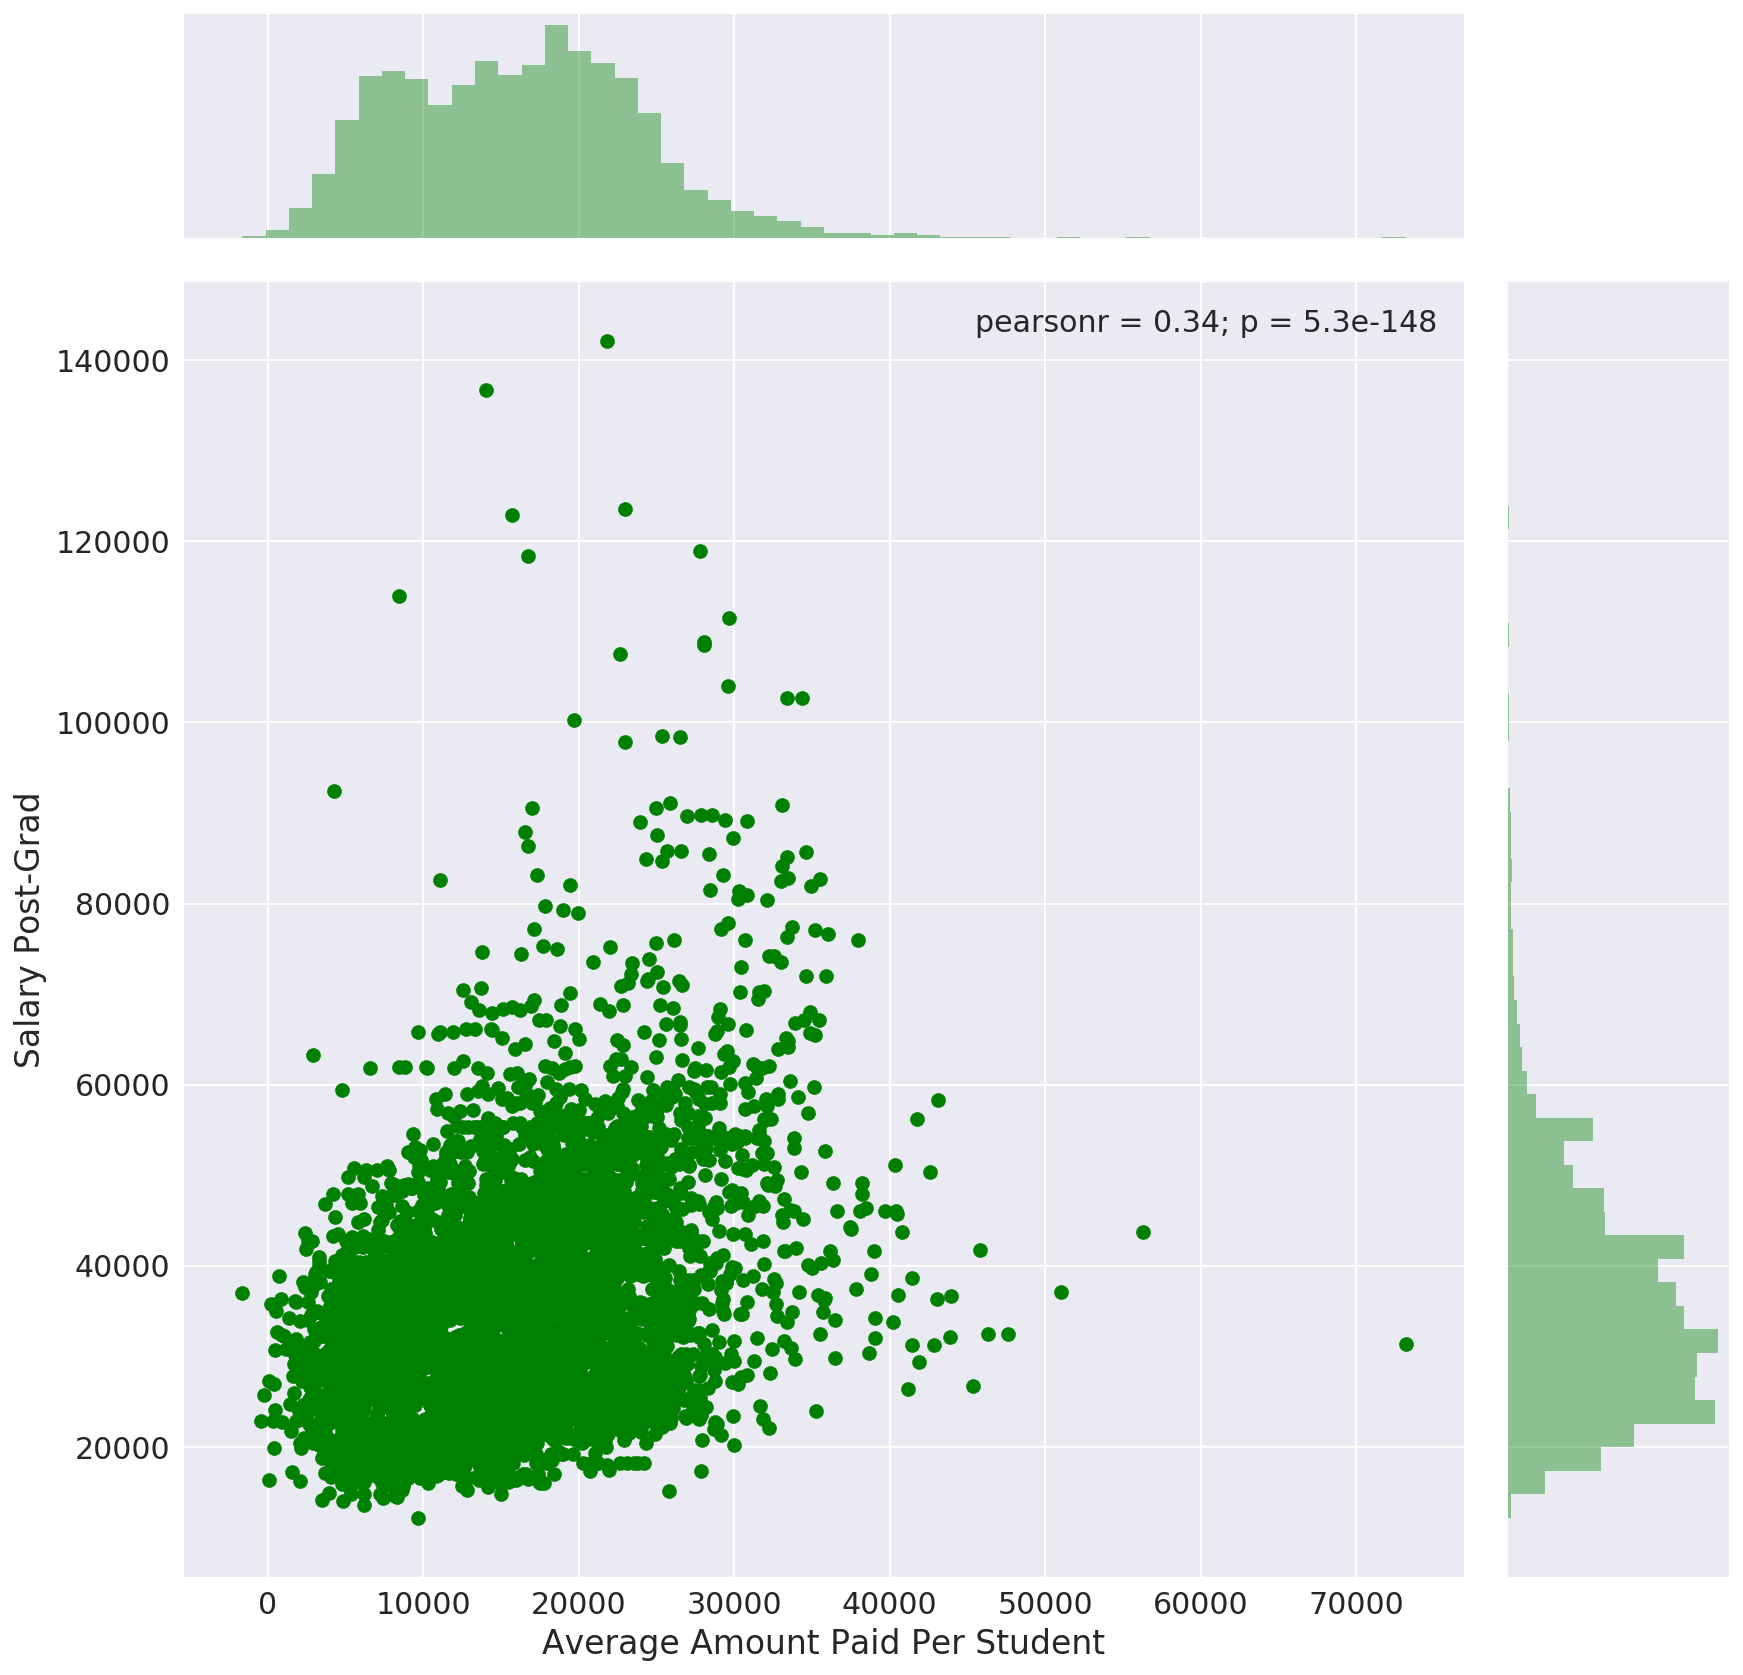

In [103]:
g = sns.jointplot(x='price', y='salary', data=school, size=12, color='g')
g.set_axis_labels('Average Amount Paid Per Student', 'Salary Post-Grad')

Almost all of the data is grouped together in one large point cloud.  Because of the density, it is difficult to see if there are any patterns among that group.  To see the relative densities in the cloud more clearly, we can plot a hex-grid heatmap.

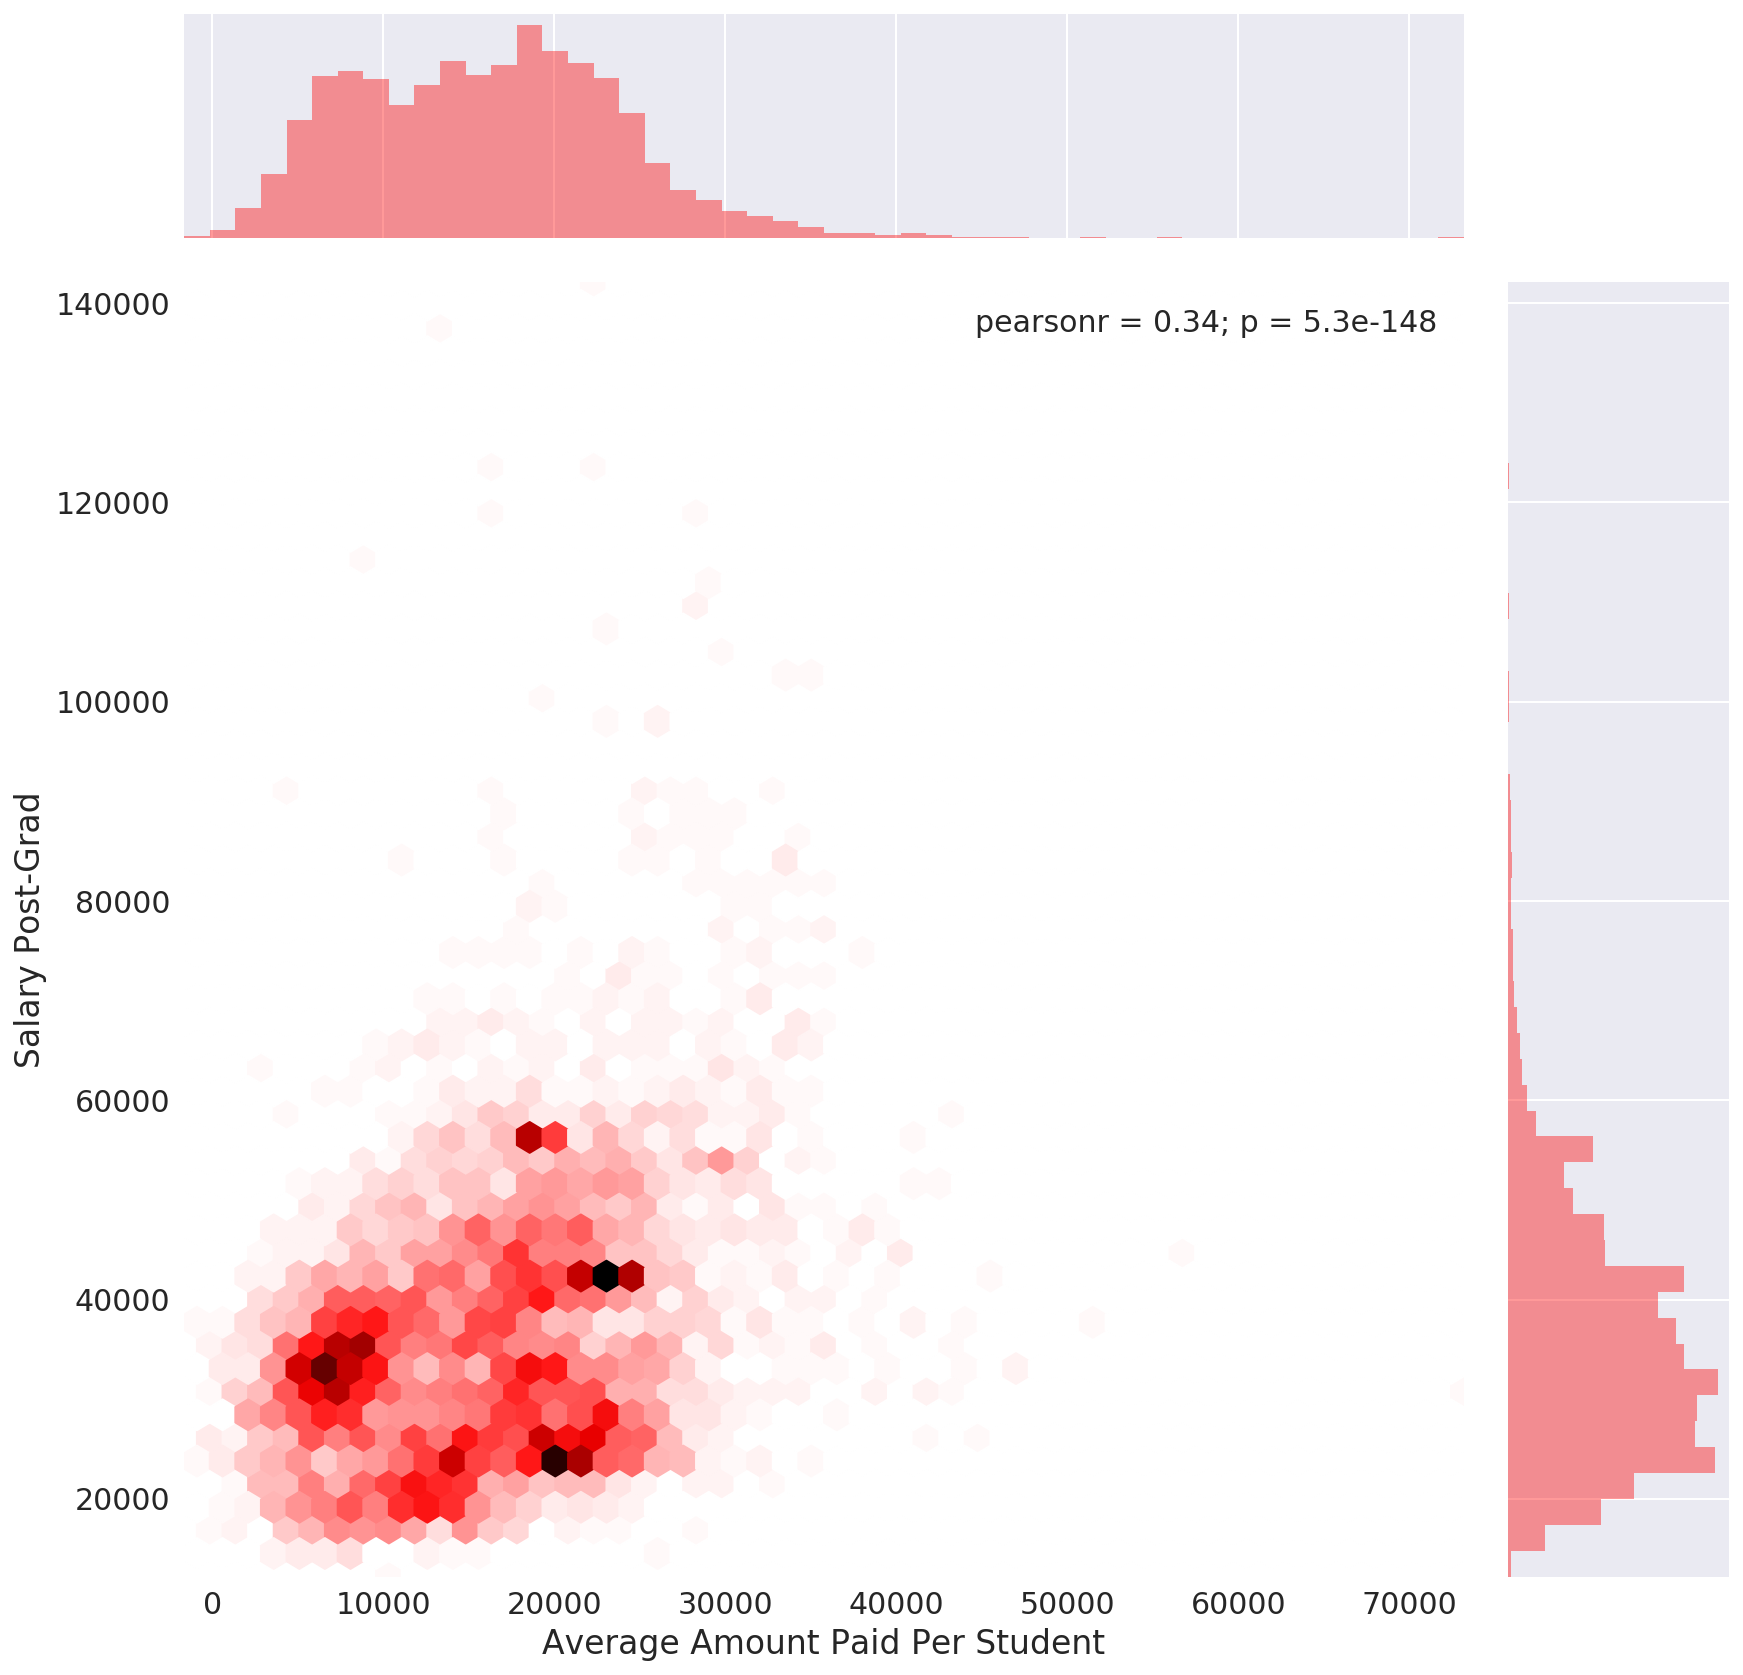

In [104]:
g = sns.jointplot(x='price', y='salary', data=school, kind='hex', size=12, color='r')
g.set_axis_labels('Average Amount Paid Per Student', 'Salary Post-Grad')

We can see that these two factors are still not particularly correlated.  There are clusters of high density in the cloud, but there is not clear pattern among them.  However, the outliers are the most interesting parts of the graph.  Points in the top left have very high salary but low cost, while points in the lower right have very high cost but low salary.  Strictly in terms of finances, we can rate the best and worst value institutions.  In our original processing, we built a column of value = salary - cost, so let's examine this.

Text(0.5,0,'Value (Salary - Cost of Attendance)')

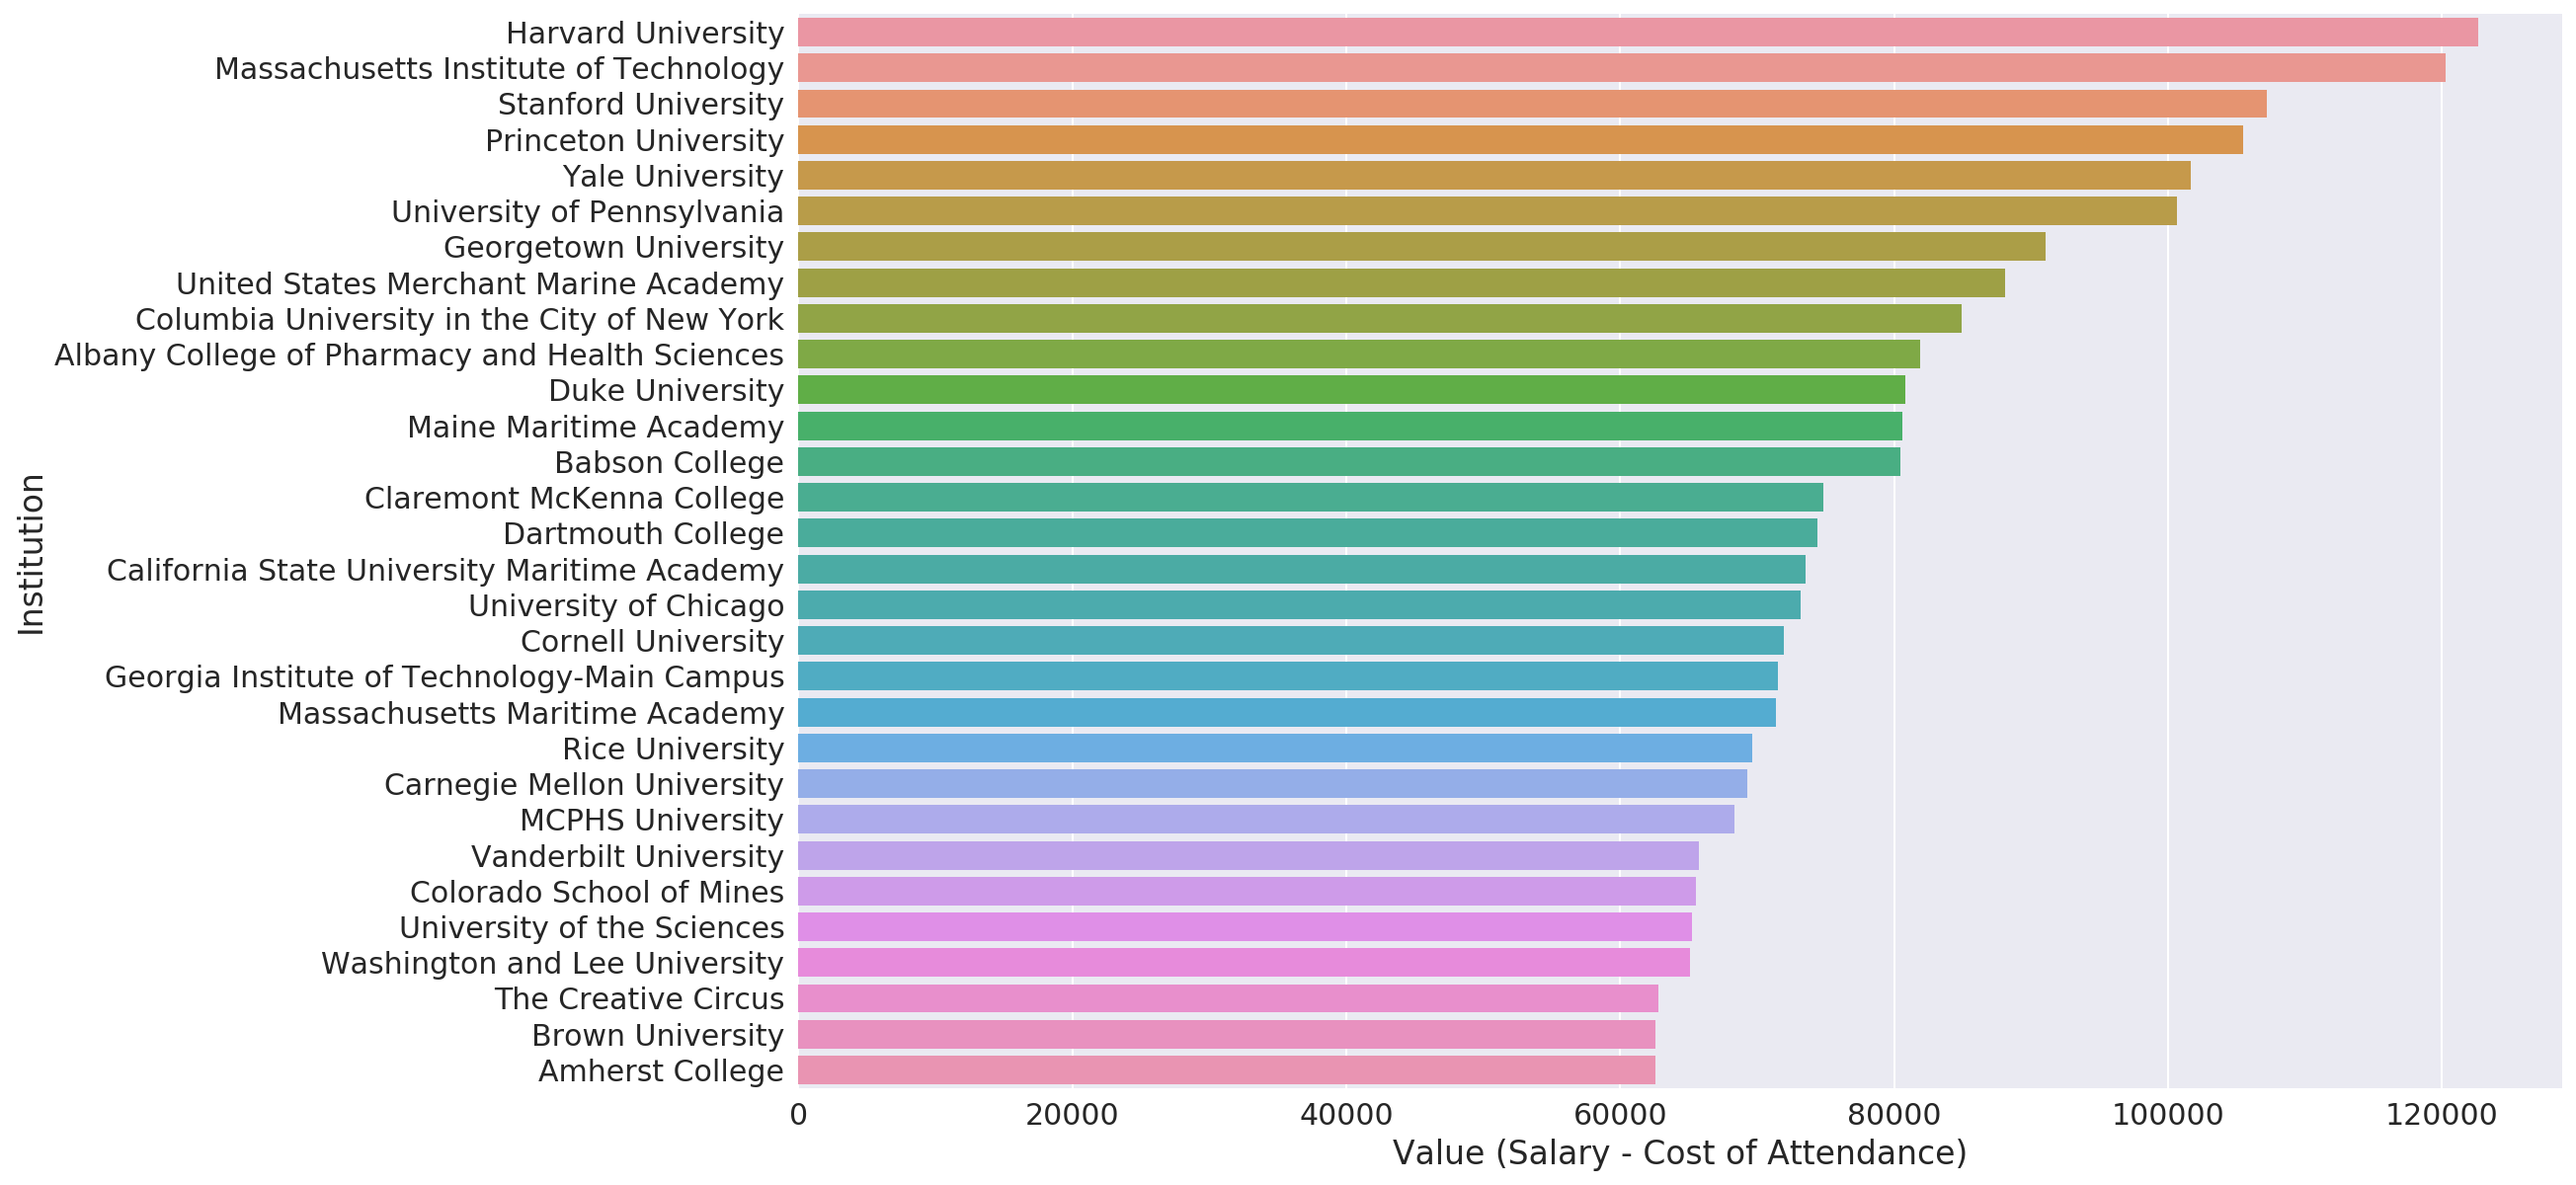

In [105]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.barplot(x='value', y='school', data=school.sort_values('value', ascending=False).head(30))
g.set_ylabel("Institution")
g.set_xlabel("Value (Salary - Cost of Attendance)")

As we might have expected, the schools with highest value are often Ivy League or are known as high ranking universities.  There are some interesting points in that there are many maritime academies, like the US Merchant Marine Academy, that place extremely well.  In looking up these schools, they have very high rates of acceptance and are not always particularly selective.  Of course, these universities offer very different post-graduation prospects than a typical university, but they are worth considering for prospective students.

There are also some specialized universities that find their way into this list.  For example, the Colorado School of Mines is not, to our knowledge, typically considered a prestigious university in the usual sense, but it boasts an extremely high value for the investment.  The Creative Circus is another example of one such school, which we found was a design school in Atlanta.

We can also examine the lowest value universities in a similar way.

Text(0.5,0,'Value (Salary - Cost of Attendance)')

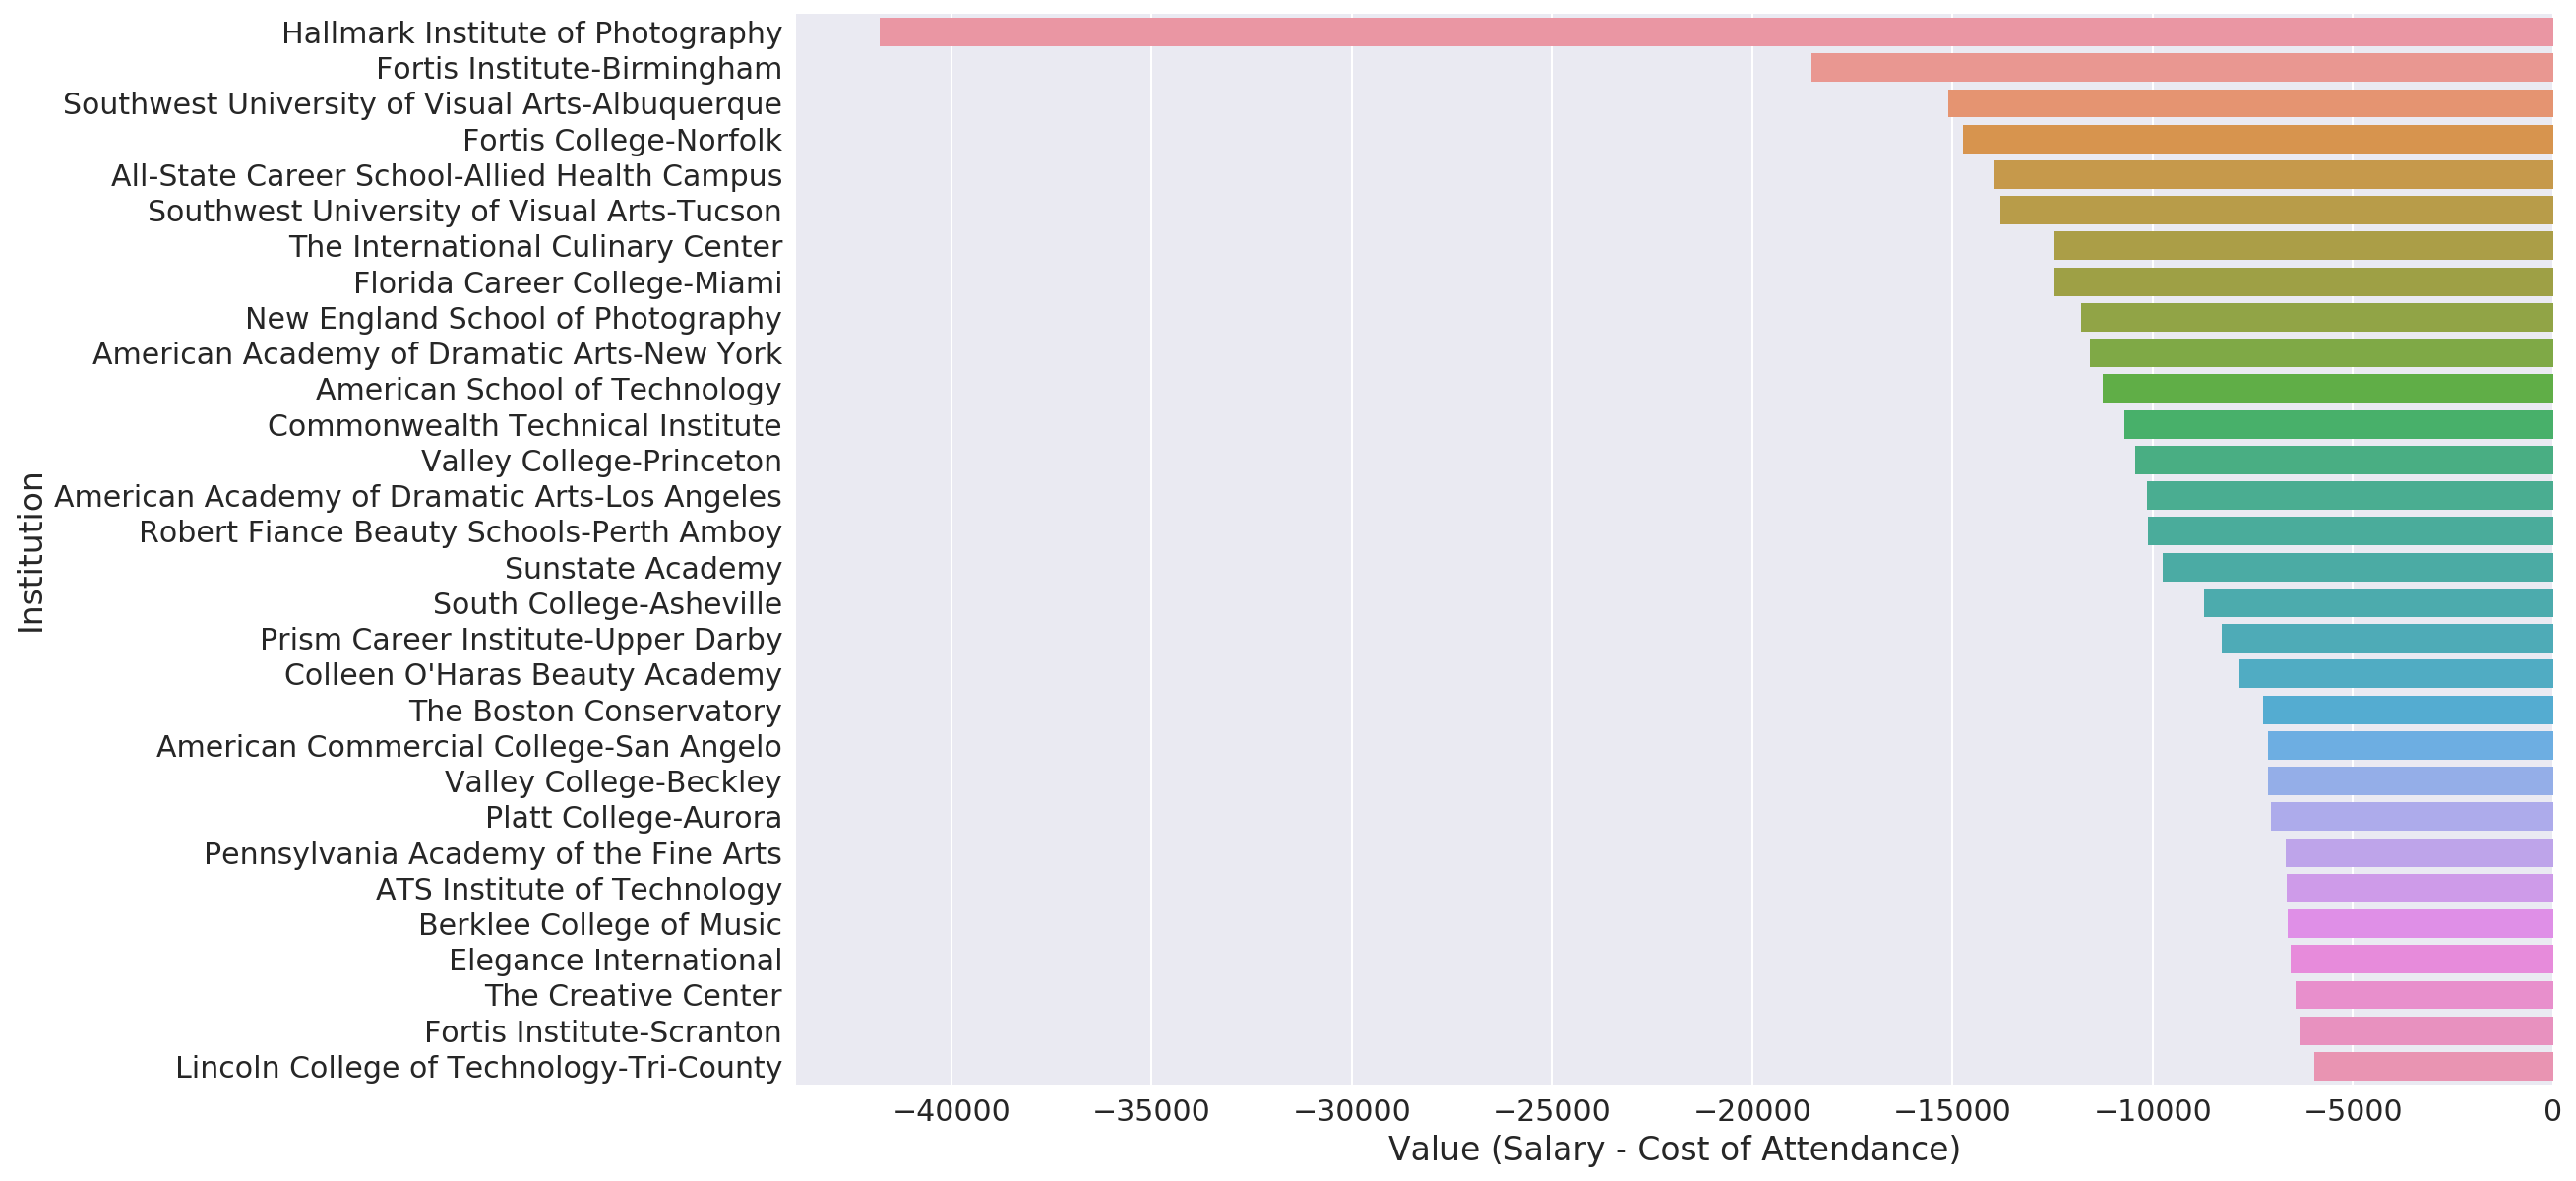

In [106]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.barplot(x='value', y='school', data=school.sort_values('value', ascending=True).head(30))
g.set_ylabel("Institution")
g.set_xlabel("Value (Salary - Cost of Attendance)")

We had never heard of the Hallmark Institute of Photography, but it ranks far worse than any other institutions and in researching it, we found that it closed in the last year or so.  Other than that, there are many art, drama, and music focused universities, reflecting the unfortunate fact of limited opportunity many for students interested in these areas.

Overall, many of these schools do not rank too far below breaking even.  In concrete terms, the salary and cost of attendance that we are deriving value from are both yearly.  So, an average of about $5,000 per year in college cost more than the typical graduate earns in a year might certainly be difficult to manage financially.  While this is only one aspect of choosing a college to consider, it is important to know when deciding.

Finally, we examine the overall trend line of the highest value universities.  We wanted to see if the steep drop-off after the highest value schools continued, so we plotted the top 500 universities.  We can see, however, that after the top 50 or so institutions, the value starts to even out and many universities rank very similarly with respect to their average financial value.

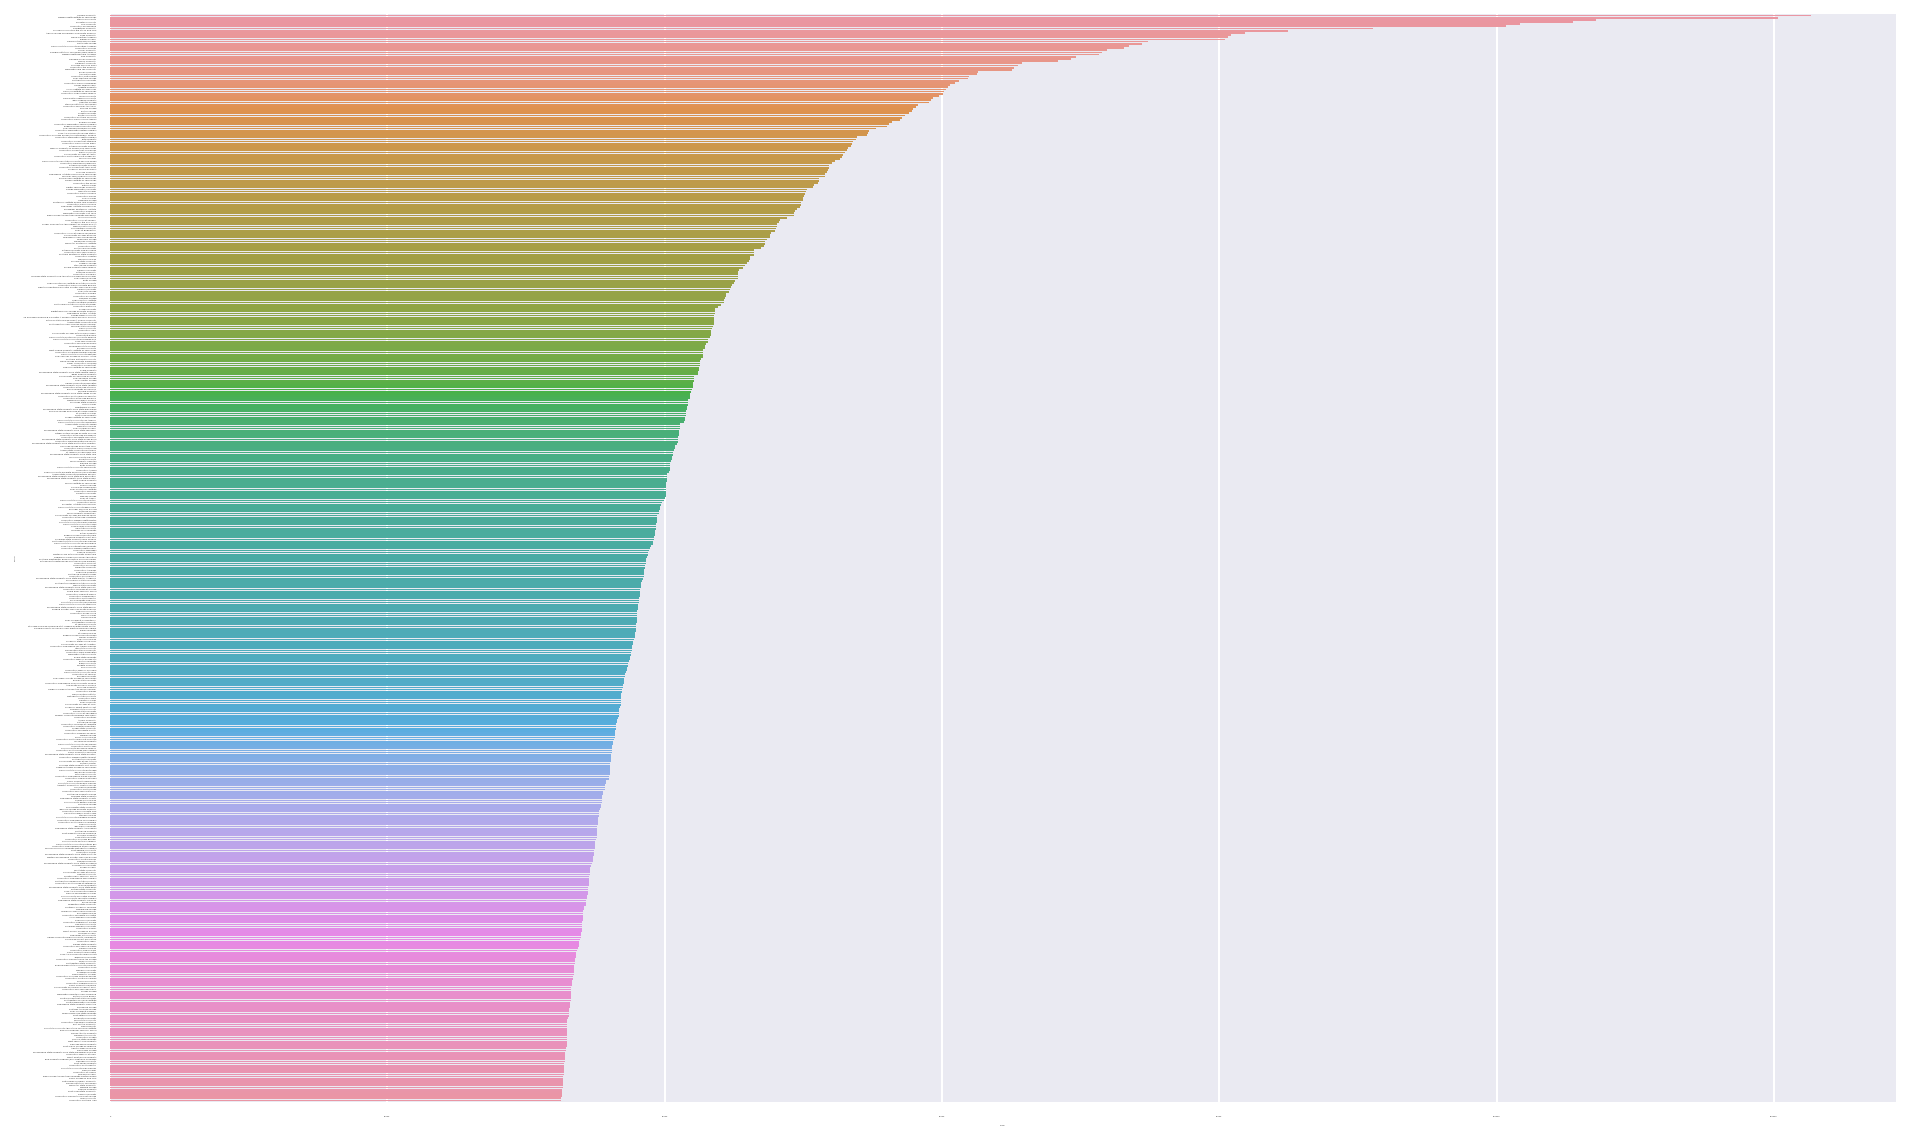

In [107]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=0)
sns.barplot(x='value', y='school', data=school.dropna().sort_values('value', ascending=False).head(500))

Text(0.5,1,'Frequency Evaluation of Differing Values')

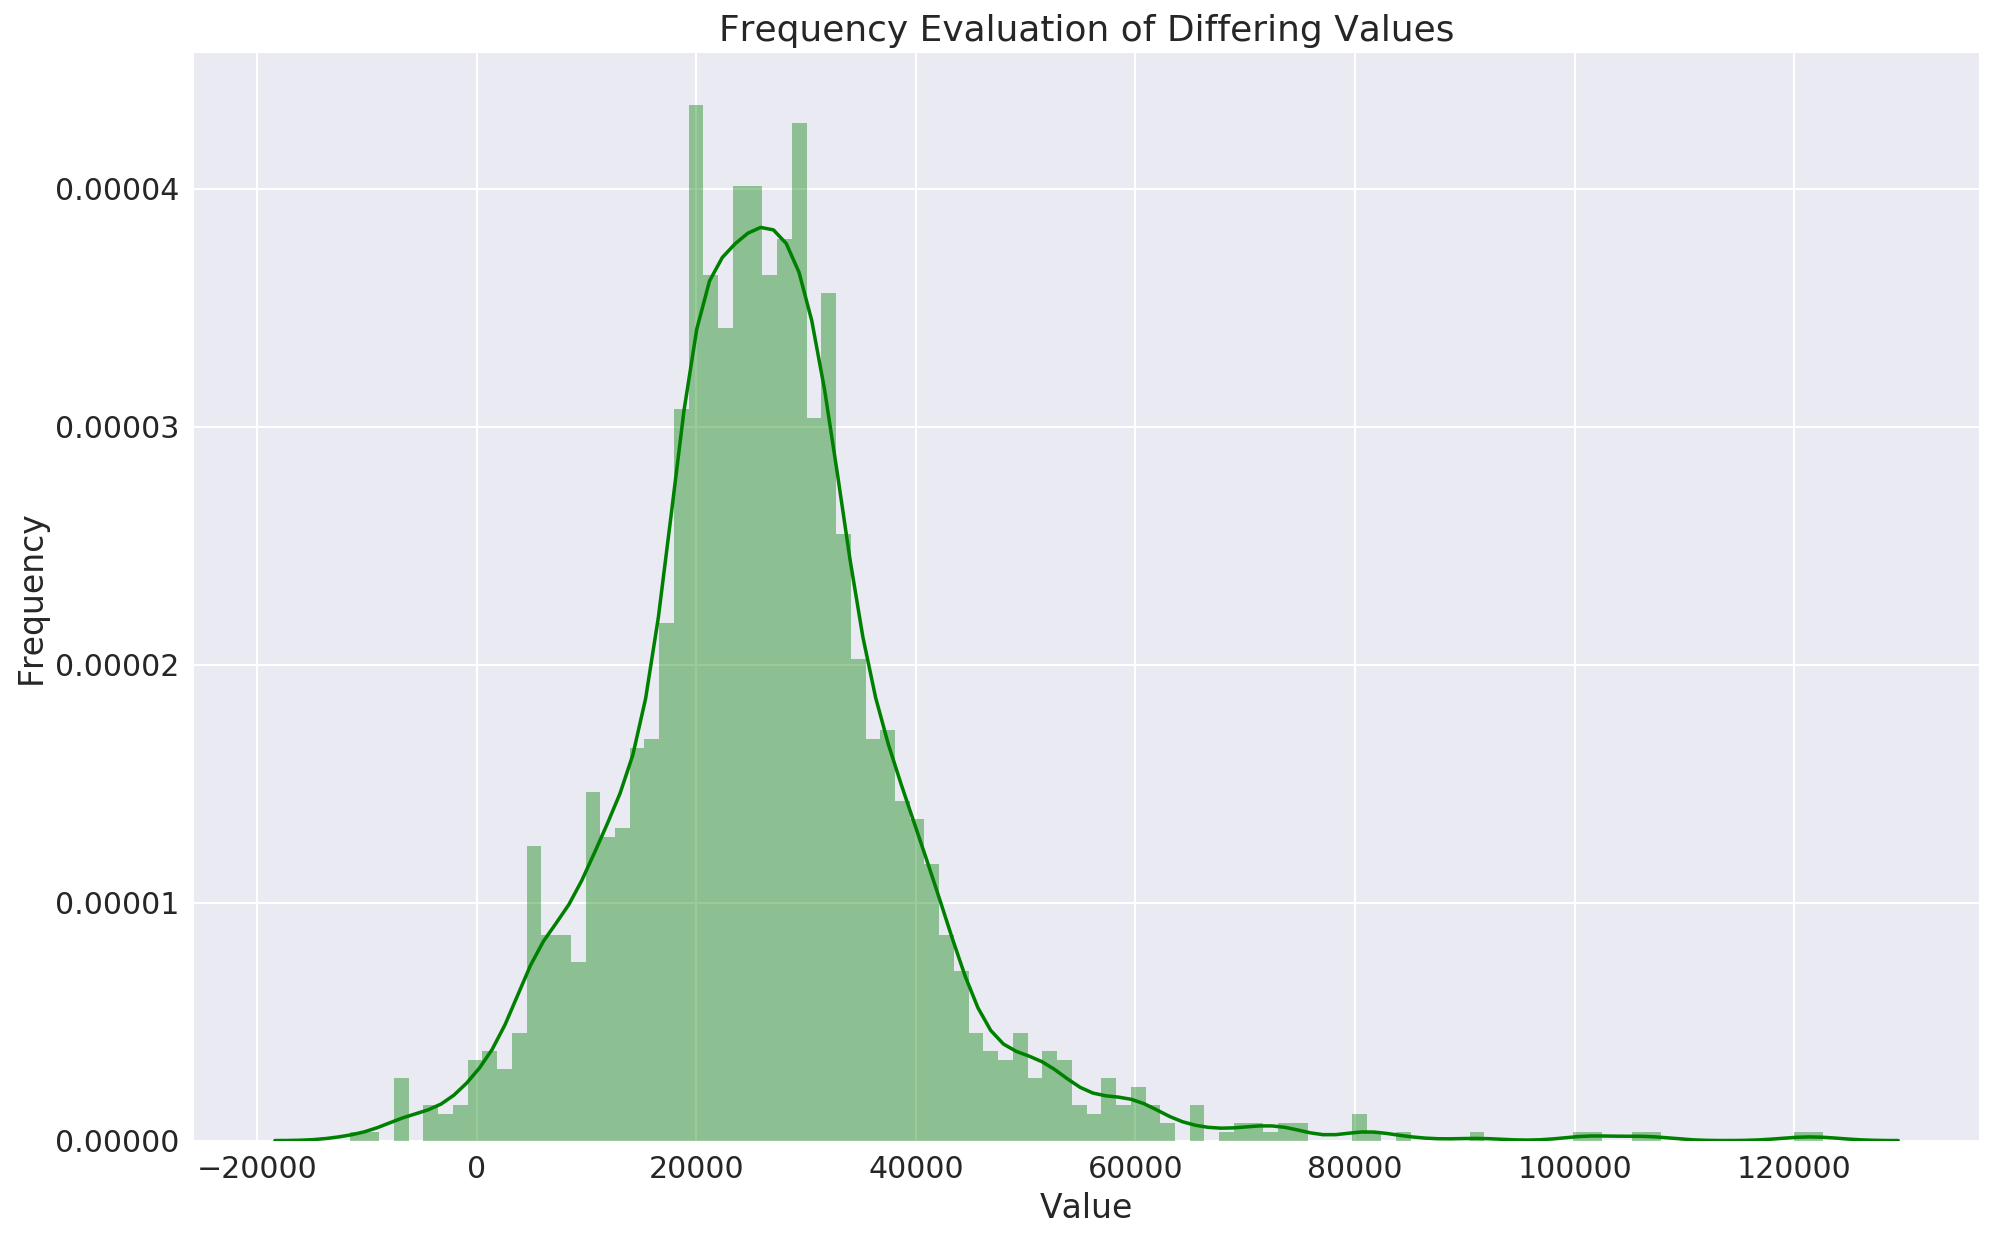

In [125]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.distplot(school.sort_values('value').dropna()['value'], bins=100, kde=True, color='g')
g.set_ylabel("Frequency")
g.set_xlabel("Value")
g.set_title("Frequency Evaluation of Differing Values")

##### Degree Type

Another aspect that incoming and ongoing students must consider is the decision to attend graduate school or enter the workforce after earning an undergraduate degree.  In our data analysis, it is important to consider the specifics of how our data set defines these numbers.  If a school primarily grants, for example, Bachelor's degrees, then the entire school average will be counted in the undergraduate category.  This means that even though Harvard does grant graduate degrees, its school average salary will be counted in the undergraduate category.  Also, we have relatively limited information on graduate universities, as many do not include cost and salary in the data set.  Therefore, we only have about 100 data points in the graduate category.  Despite these caveats, there is still a very clear pattern that emerges when examining average salary.

Text(0.5,1,'Salary Comparison Between Graduating Degrees')

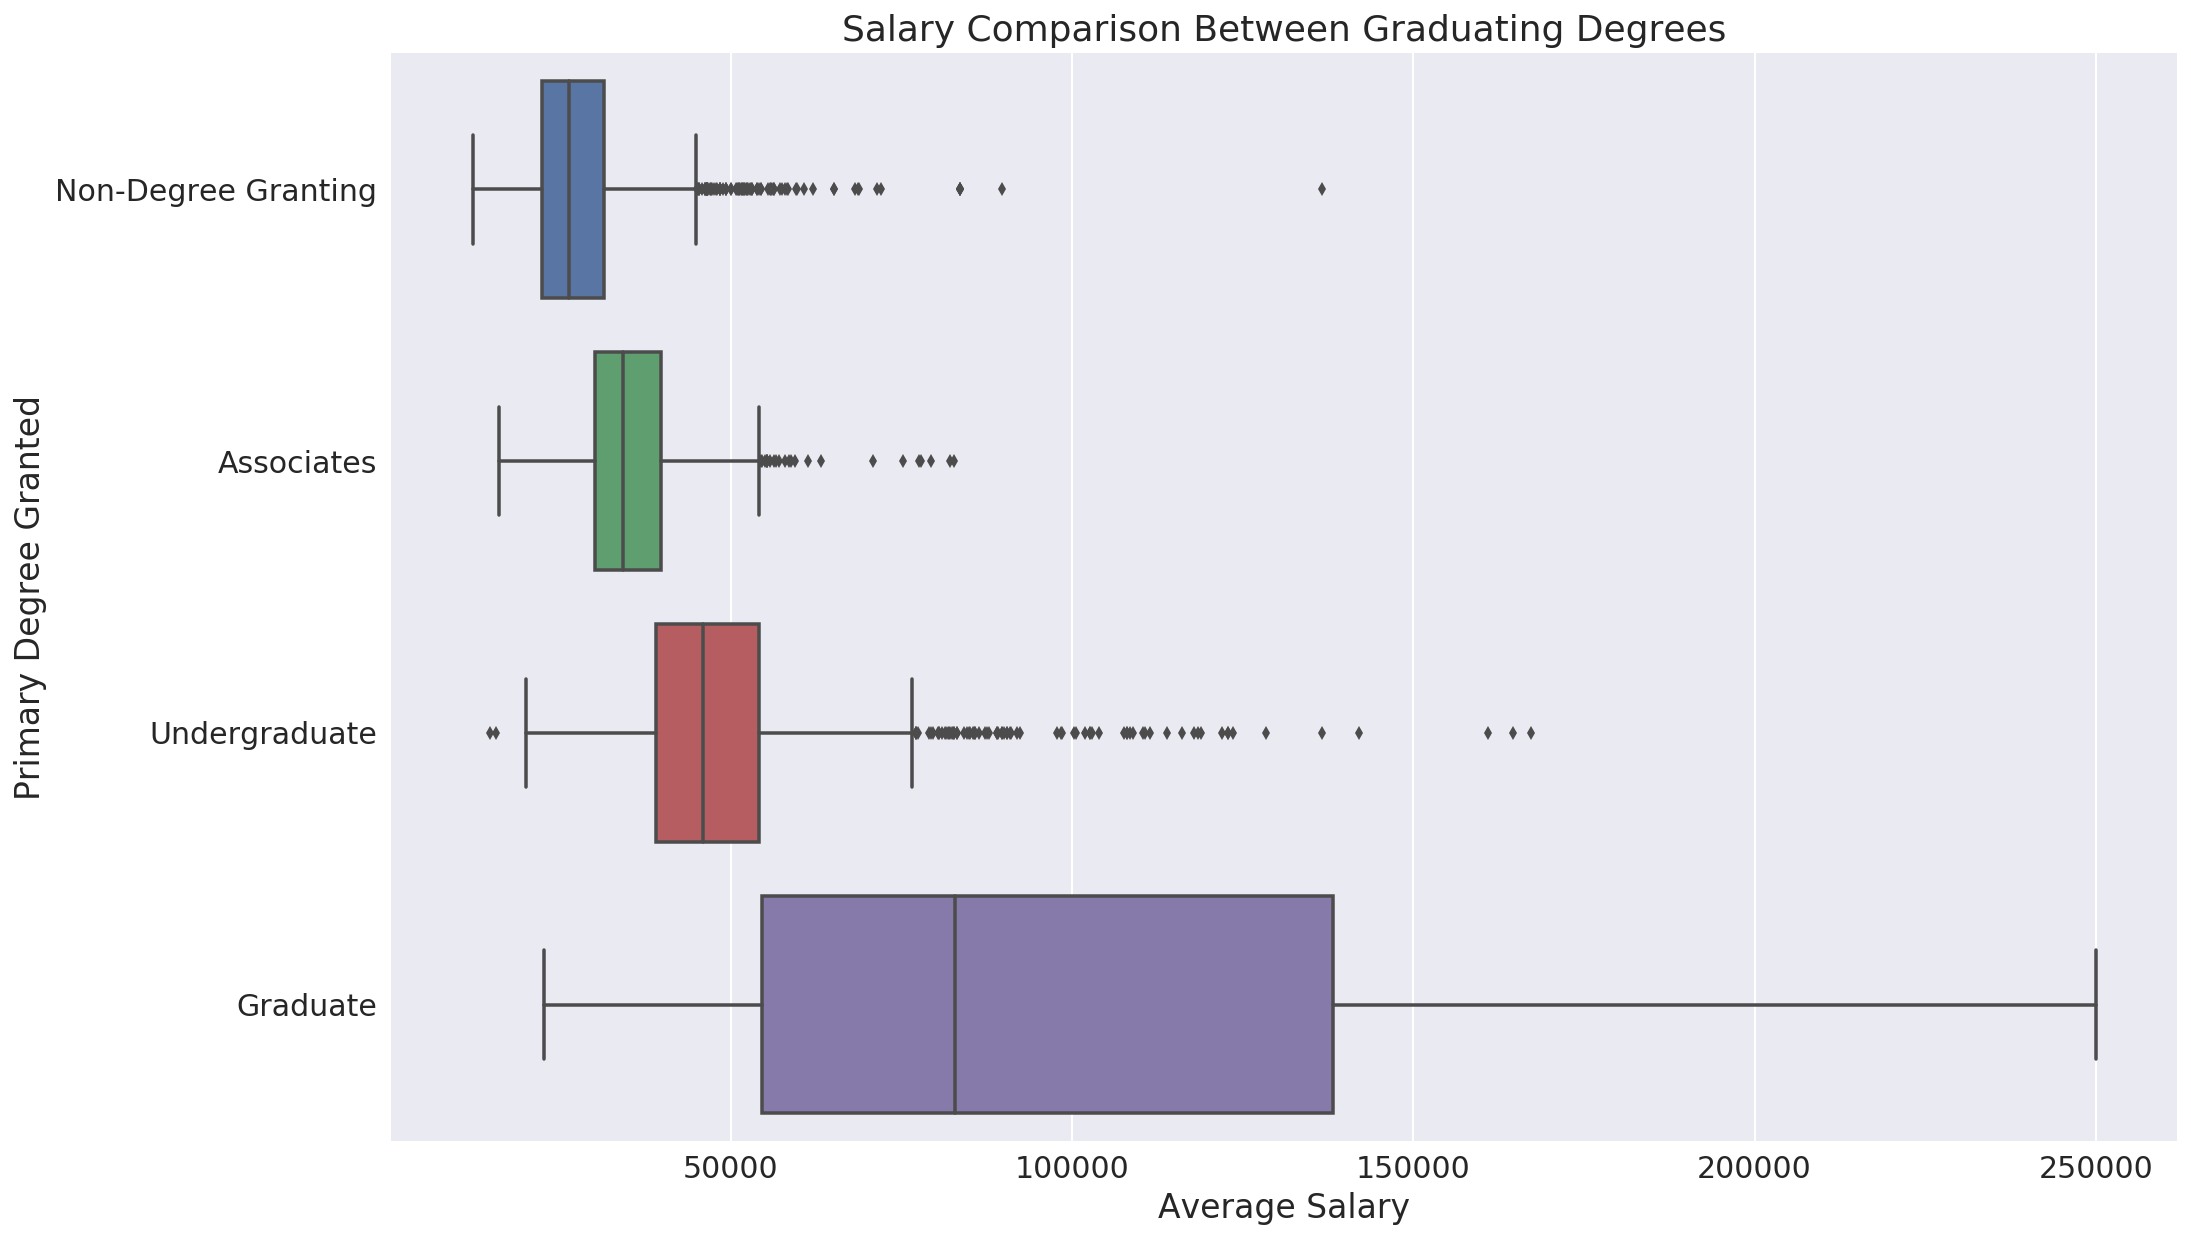

In [109]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x=school['salary'], y=school['primary_degree'],
                order=['Non-Degree Granting', 'Associates', 'Undergraduate', 'Graduate'],
                orient='h')
g.set_ylabel("Primary Degree Granted")
g.set_xlabel("Average Salary")
g.set_title("Salary Comparison Between Graduating Degrees")

There is a very clear pattern here that higher degrees do correlate with higher average salaries.  From the first to third box plot, there is a slight increase at each step, with undergraduate significantly increasing the upper bound from associates but keeping a fairly close average.  Graduate salaries, however, completely dwarf the other three.  We assumed this might be because graduate schools might be primarily full of medical schools.  To eliminate some or most of these graduate institutions we can exclude entries with names that include 'Medical' or 'Health'.

Text(0.5,0,'Average Salary')

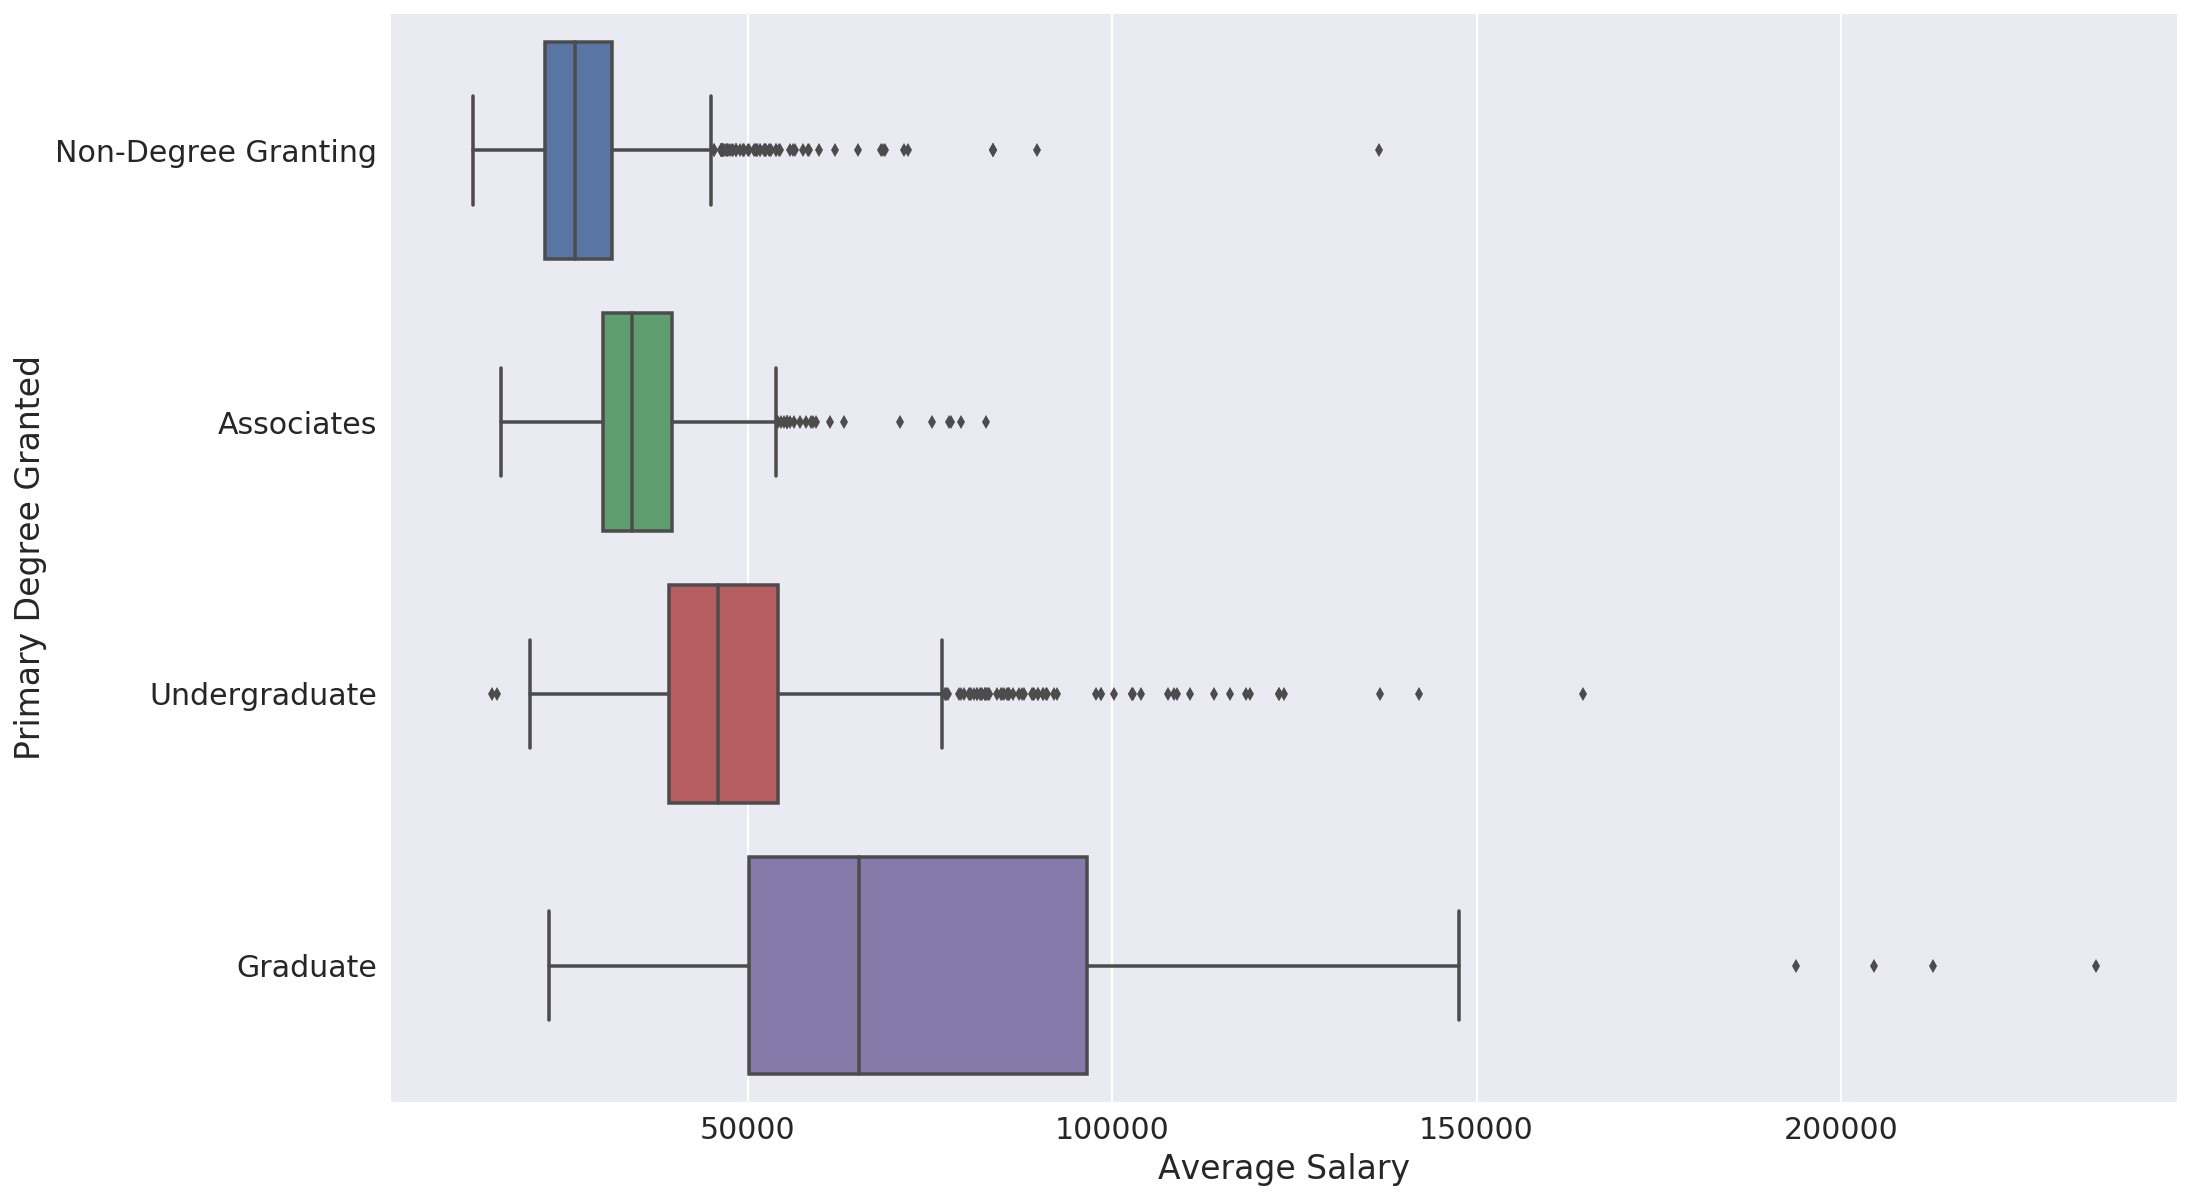

In [110]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x=school['salary'],
                y=school[(~school['school'].str.contains('Health')) & (~school['school'].str.contains('Medical'))]['primary_degree'],
                order=['Non-Degree Granting', 'Associates', 'Undergraduate', 'Graduate'],
                orient='h')
g.set_ylabel("Primary Degree Granted")
g.set_xlabel("Average Salary")

Even after eliminating most medical schools, there is a huge increase in average salary for students with graduate degrees.  While the value of graduate degrees can, of course, vary greatly between disciplines, it seems that overall graduate degrees are typically a good investment.

##### Public, Private or Non-Profit

Universities are also split up into their respective categories of ownership.  We can examine the values between public, private, and non-profit universities to see if these difference have any relationship with value.

Text(0.5,1,'Value Comparison Between Institution Ownership Categories')

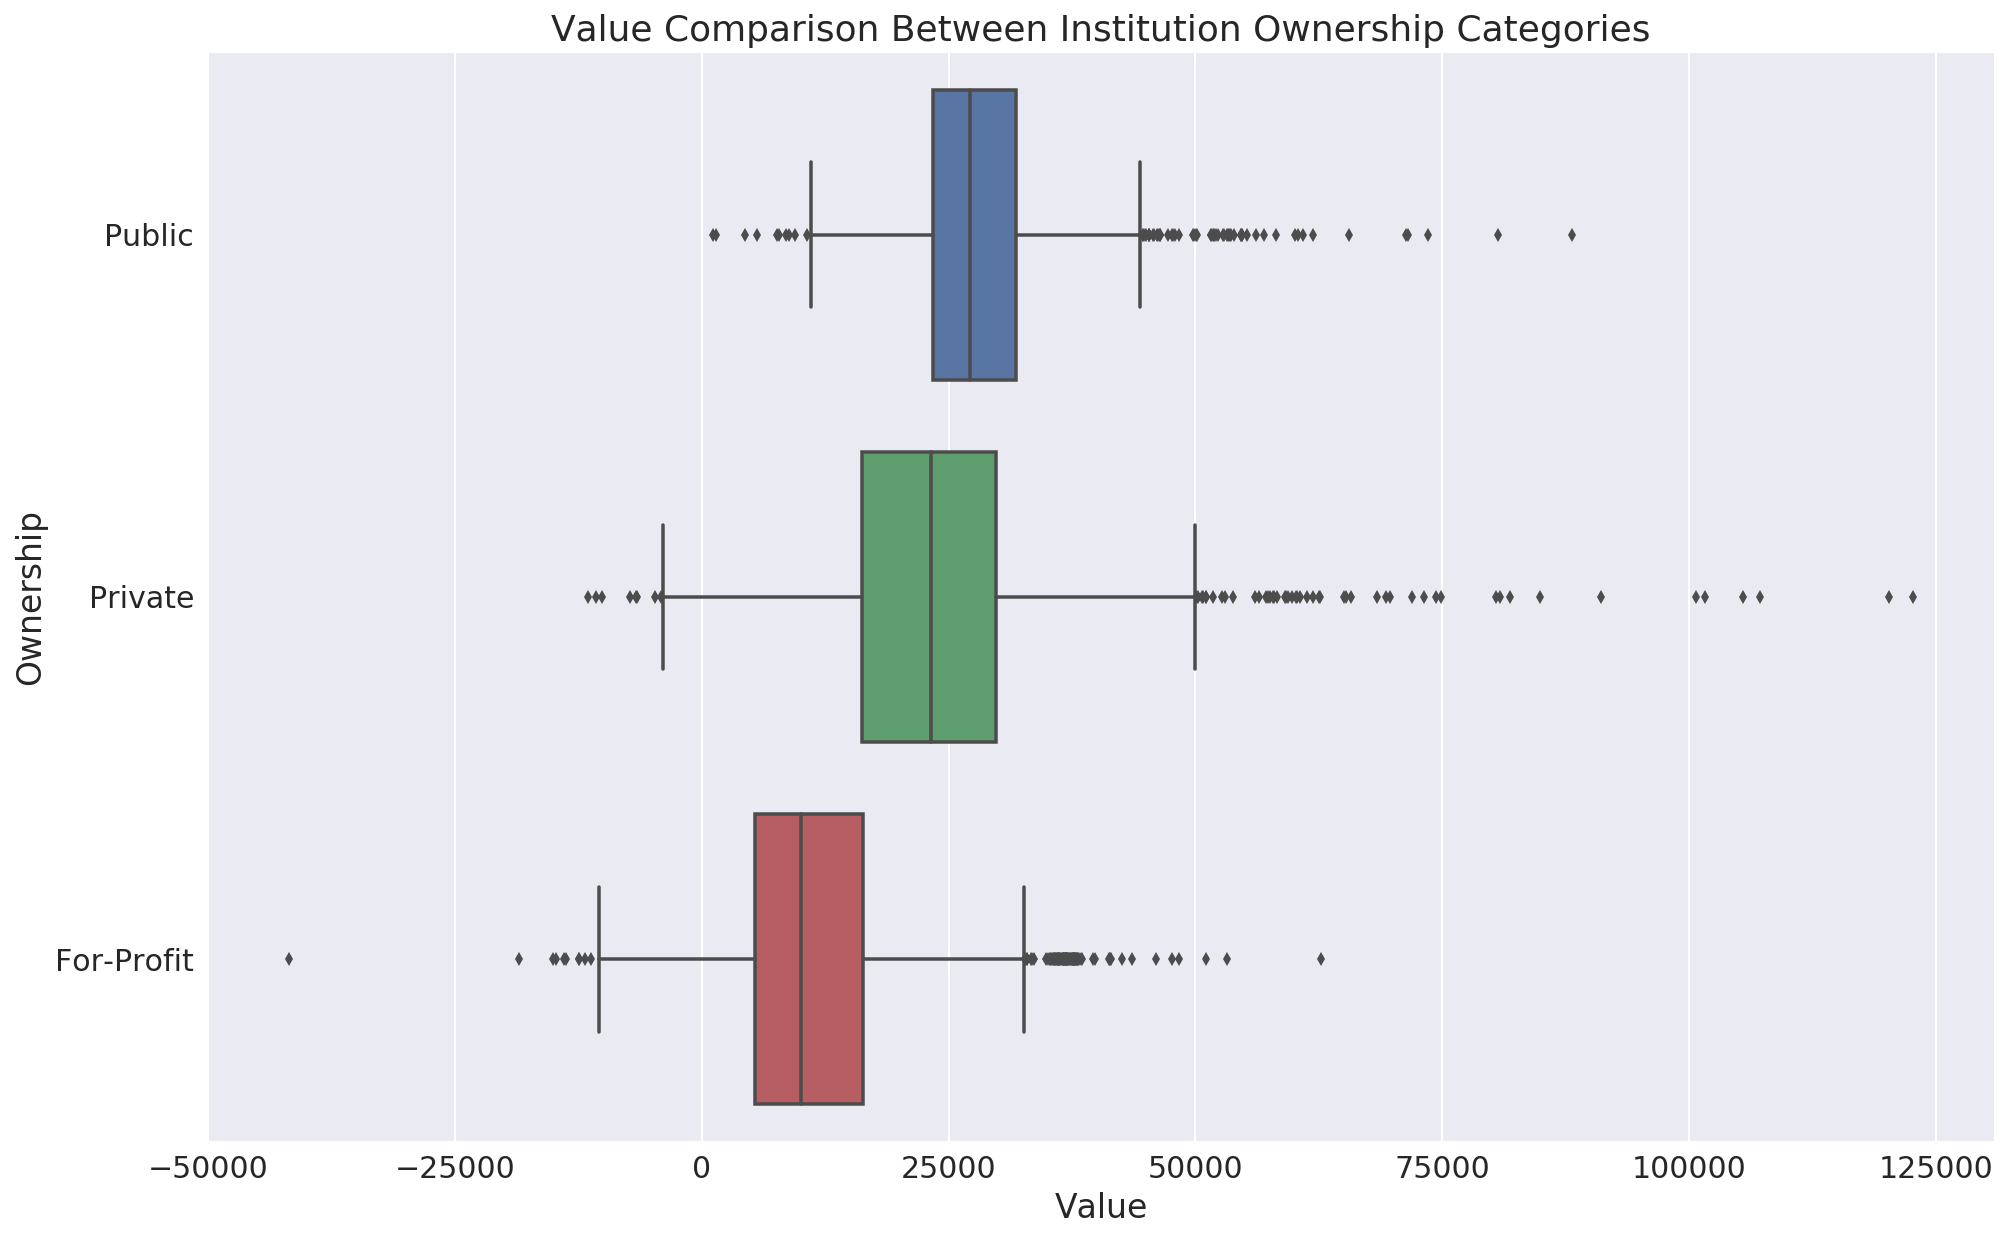

In [111]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x=school['value'], y=school['owned'],
                order=['Public', 'Private', 'For-Profit'],
                orient='h')
g.set_ylabel("Ownership")
g.set_xlabel("Value")
g.set_title("Value Comparison Between Institution Ownership Categories")

There is a fairly clear pattern that public universities give the best average value, followed by private, with for-profit institutions giving the lowest average values.  It is important to consider that there are outliers in each category and that the outliers for private universities far exceed those of public universities.  If a prospective student earns an offer of admission to some of the highest value private institutions mentioned above, these are the clearest higher values.  However, for the average student public institutions seem to be the best option.  We expect that these values are mostly influenced by students attending colleges in their state of residence, as out-of-state tuition and expenses tend to be much higher, though we are unable to pull this data from this dataset.

##### Clustering
To further our analysis of these universities, we employ KMeans clustering to group these universities into 3 categories: high, medium, and low financial value.  We use sklearn to implement our unsupervised learning.  Since we are only grouping in one dimension, we should see an even split of the data into 3 even categories that should show nicely in a graph.

The main idea behind segmenting our data points into value categories is to get an intuitive idea of what the schools ranking in each category have in common.

In [112]:
from sklearn.cluster import KMeans

school.dropna(subset=['value'], inplace=True)
km = KMeans(n_clusters=3).fit_predict(school['value'].reshape(-1, 1))
school['cluster'] = km
school.head(10)

/home/syncytium/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


,school,salary,cost,primary_degree,price,admission_rate,completion,owned,class_size,value,finaid,cluster
0,Alabama A & M University,34300.0,18888.0,Undergraduate,13415.0,0.8989,0.2914,Public,4051.0,20885.0,5473.0,0
1,University of Alabama at Birmingham,46400.0,19990.0,Undergraduate,14805.0,0.8673,0.5377,Public,11200.0,31595.0,5185.0,0
2,Amridge University,46100.0,12300.0,Undergraduate,7455.0,NaN,0.6667,Private,322.0,38645.0,4845.0,1
3,University of Alabama in Huntsville,50500.0,20306.0,Undergraduate,17520.0,0.8062,0.4835,Public,5525.0,32980.0,2786.0,1
4,Alabama State University,29500.0,17400.0,Undergraduate,11936.0,0.5125,0.2517,Public,5354.0,17564.0,5464.0,0
5,The University of Alabama,49900.0,26717.0,Undergraduate,21513.0,0.5655,0.6665,Public,28692.0,28387.0,5204.0,0
6,Central Alabama Community College,30900.0,12103.0,Associates,6407.0,NaN,0.0909,Public,1779.0,24493.0,5696.0,0
8,Auburn University at Montgomery,37900.0,16556.0,Undergraduate,11915.0,0.8371,0.2705,Public,4322.0,25985.0,4641.0,0
9,Auburn University,54100.0,23788.0,Undergraduate,17541.0,0.8274,0.6792,Public,19761.0,36559.0,6247.0,1
10,Birmingham Southern College,51000.0,44167.0,Undergraduate,21406.0,0.6422,0.6192,Private,1181.0,29594.0,22761.0,0


In [113]:
# rename the clusters
# 3 is highest value, 2 is medium, 1 is lowest
school['cluster'].replace(1, 'High', inplace=True)
school['cluster'].replace(0, 'Medium', inplace=True)
school['cluster'].replace(2, 'Low', inplace=True)

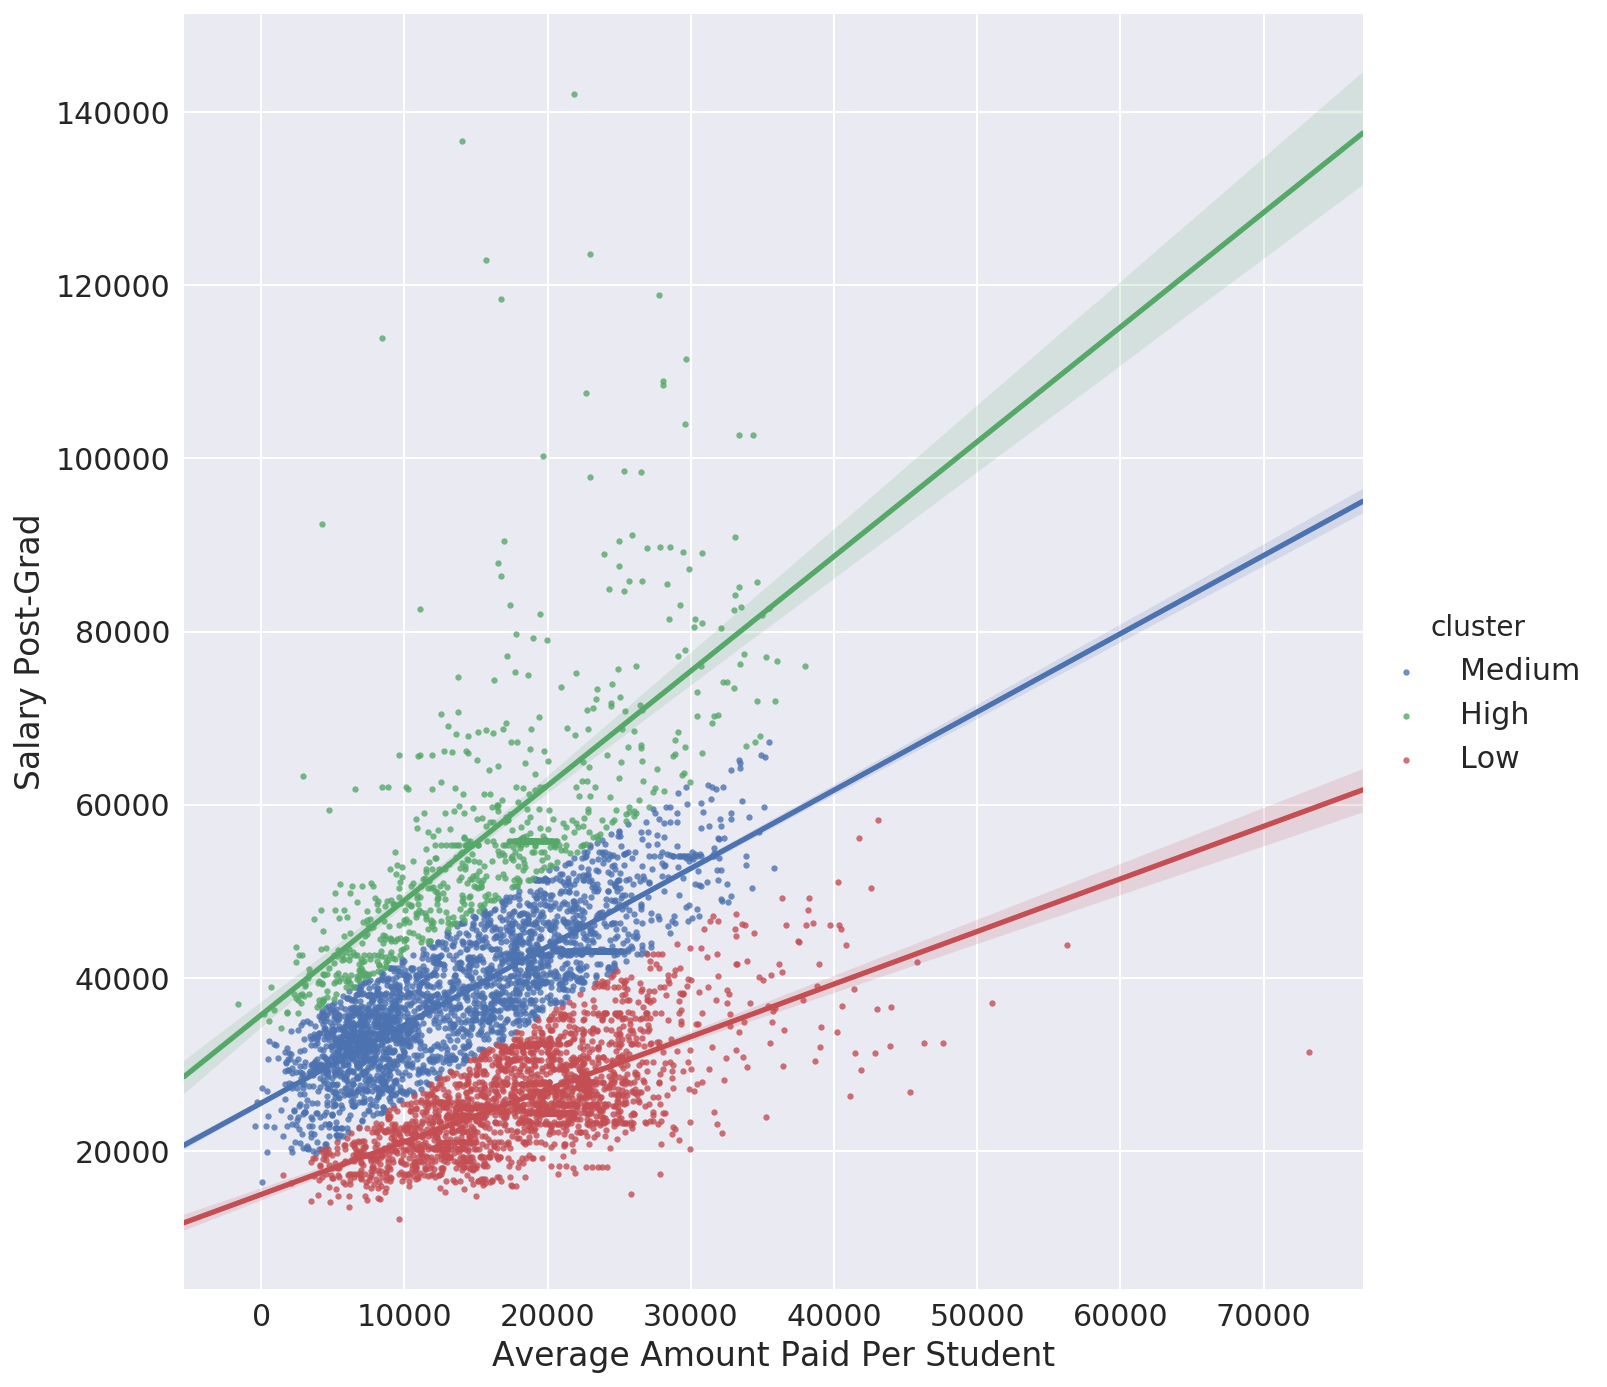

In [114]:
sns.set(font_scale=1.5)
g = sns.lmplot(x='price', y='salary', hue='cluster', data=school,
               scatter_kws={"s": 10}, size=10)

g.set_axis_labels('Average Amount Paid Per Student', 'Salary Post-Grad')
# g.set_ylabel("Institution")
# g.set_xlabel("Value (Salary - Cost of Attendance)")

We see that our splits very even and clear since we grouped by value, which is linearly derived from price and salary.  With this split, we can now examine examine different aspects of each group of university.  For example, we first examine admission rates of each category.  It is important to consider that the majority of universities do not report this, so only 2,500 of the 7,500 universities have this data.

Text(0.5,1,'Admission Rate Comparison Between Value Clusters')

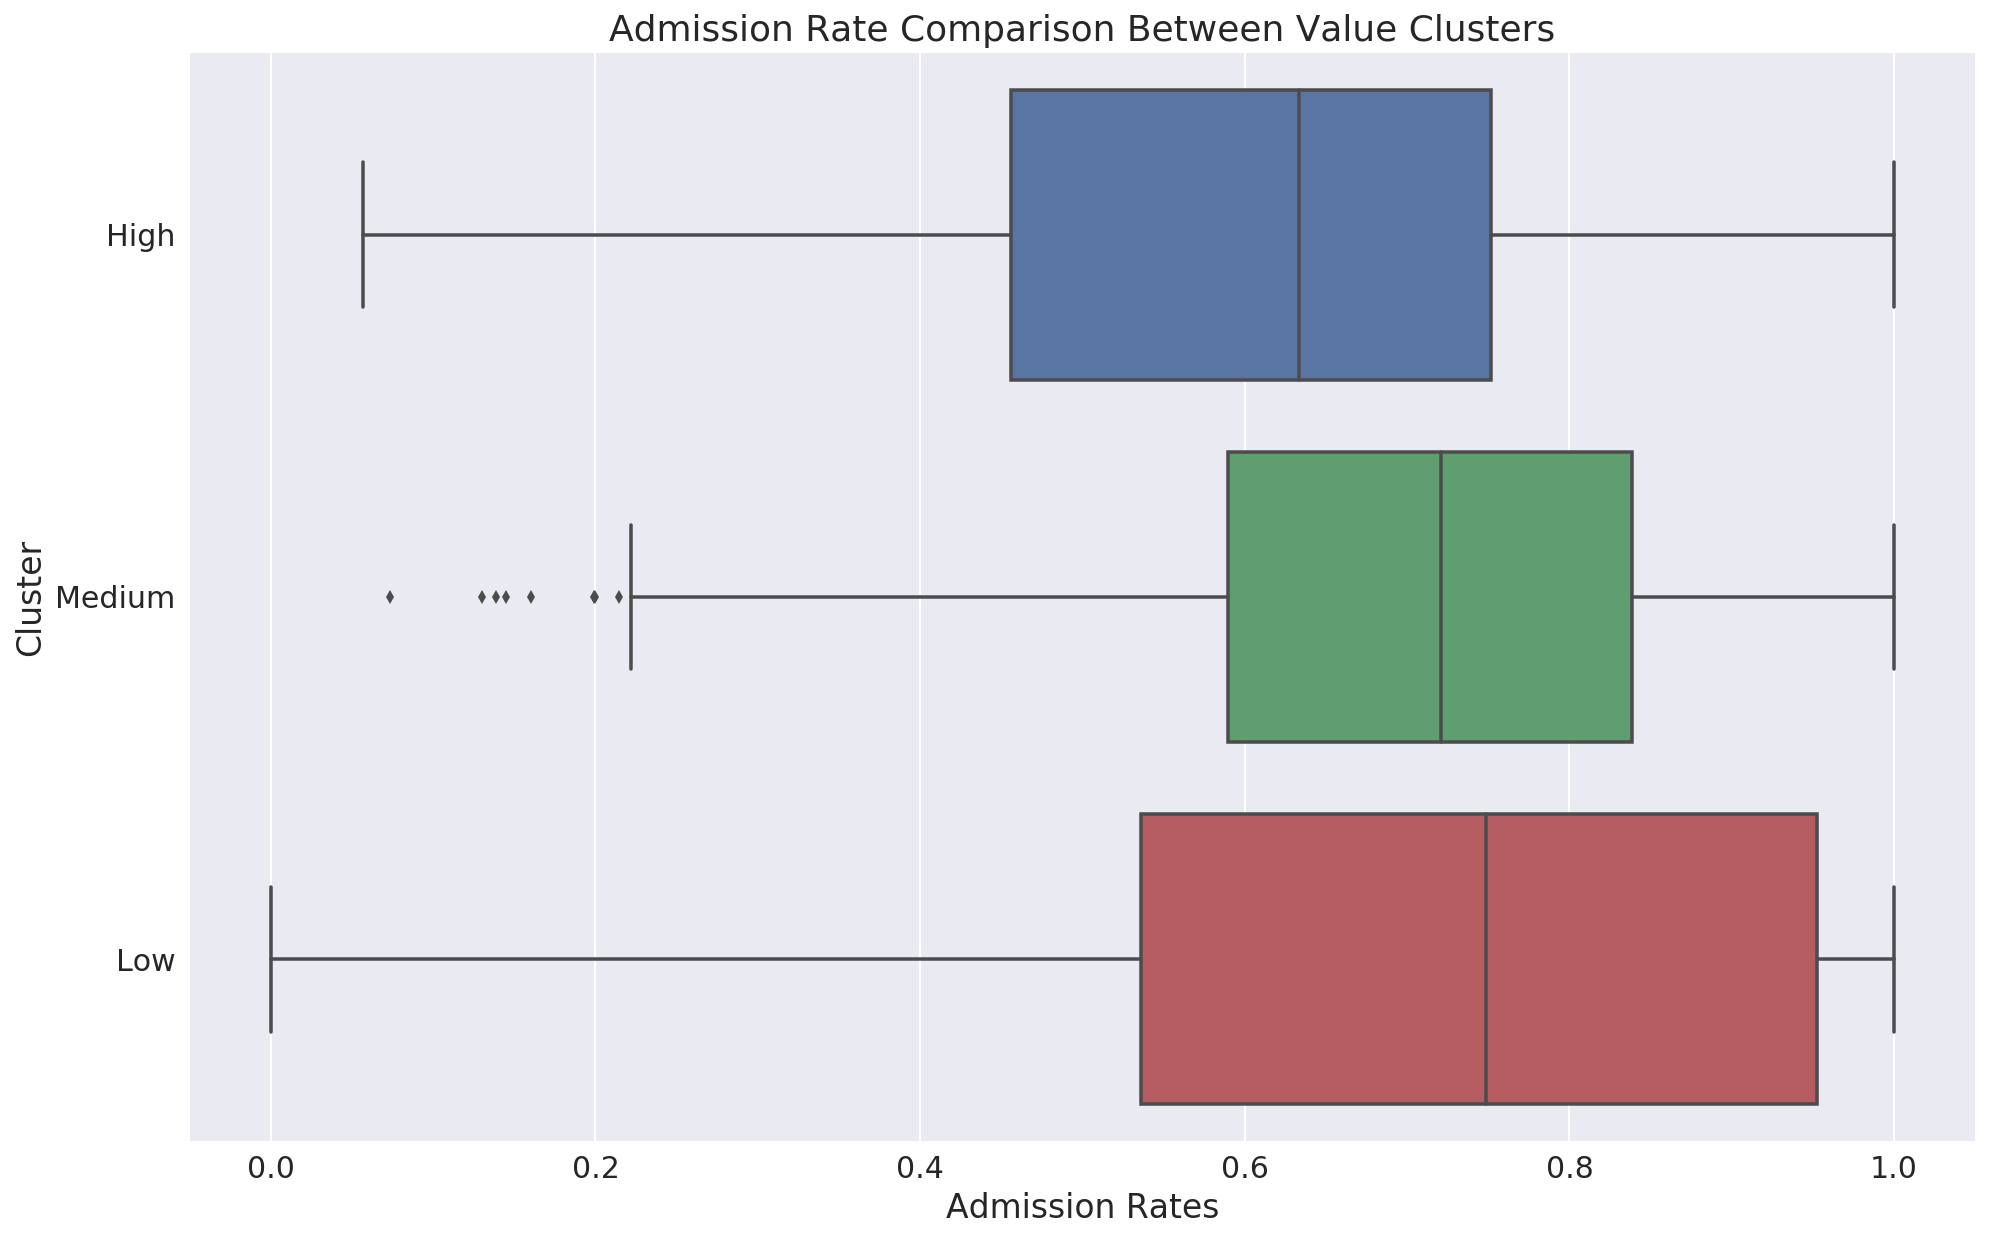

In [115]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x='admission_rate',
                y='cluster',
                data=school.dropna(subset=['admission_rate']),
                order=['High', 'Medium', 'Low'],
                orient='h')
g.set_ylabel("Cluster")
g.set_xlabel("Admission Rates")
g.set_title("Admission Rate Comparison Between Value Clusters")

There is not a particularly strong correlation here, indicating that some of the best schools in terms of value (cluster 3) are not particularly selective in their admissions process.  To give concrete examples, here is a list of 20 high-value universities with greater than 95% acceptance rates.

In [116]:
school[(school['admission_rate'] > 0.95) & (school['cluster'] == 'High')].head(20)

,school,salary,cost,primary_degree,price,admission_rate,completion,owned,class_size,value,finaid,cluster
759,Adventist University of Health Sciences,54600.0,21358.0,Undergraduate,18901.0,0.9762,0.3953,Private,2064.0,35699.0,2457.0,High
995,Brigham Young University-Idaho,46700.0,10438.0,Undergraduate,7409.0,0.9963,0.6011,Private,20208.0,39291.0,3029.0,High
1383,Kansas State University,49700.0,20140.0,Undergraduate,15852.0,0.9591,0.5944,Public,19647.0,33848.0,4288.0,High
1935,Metropolitan State University,49200.0,18170.0,Undergraduate,12314.0,1.0000,0.3387,Public,7322.0,36886.0,5856.0,High
2041,Grand River Technical School,38900.0,8576.0,Non-Degree Granting,698.0,1.0000,0.8000,Public,90.0,38202.0,7878.0,High
2110,Park University,49600.0,21351.0,Undergraduate,12335.0,0.9638,0.4345,Private,9723.0,37265.0,9016.0,High
2451,College of Staten Island CUNY,45100.0,14298.0,Undergraduate,7364.0,0.9975,0.2912,Public,12974.0,37736.0,6934.0,High
3077,East Central University,40300.0,13735.0,Undergraduate,7325.0,0.9814,0.3384,Public,3757.0,32975.0,6410.0,High
3748,University of Houston-Downtown,47400.0,18879.0,Undergraduate,10898.0,0.9509,0.1408,Public,13297.0,36502.0,7981.0,High
3850,The University of Texas at El Paso,42200.0,15272.0,Undergraduate,7586.0,0.9981,0.3946,Public,19527.0,34614.0,7686.0,High


We can also examine class sizes amongst each cluster of university.  Typically universities in the higher clusters are more selective and small classroom sizes are usually associated with higher quality education, so we expect the class size to be generally smaller in the higher clusters.

Text(0.5,1,'Class Size Comparison Between Value Clusters')

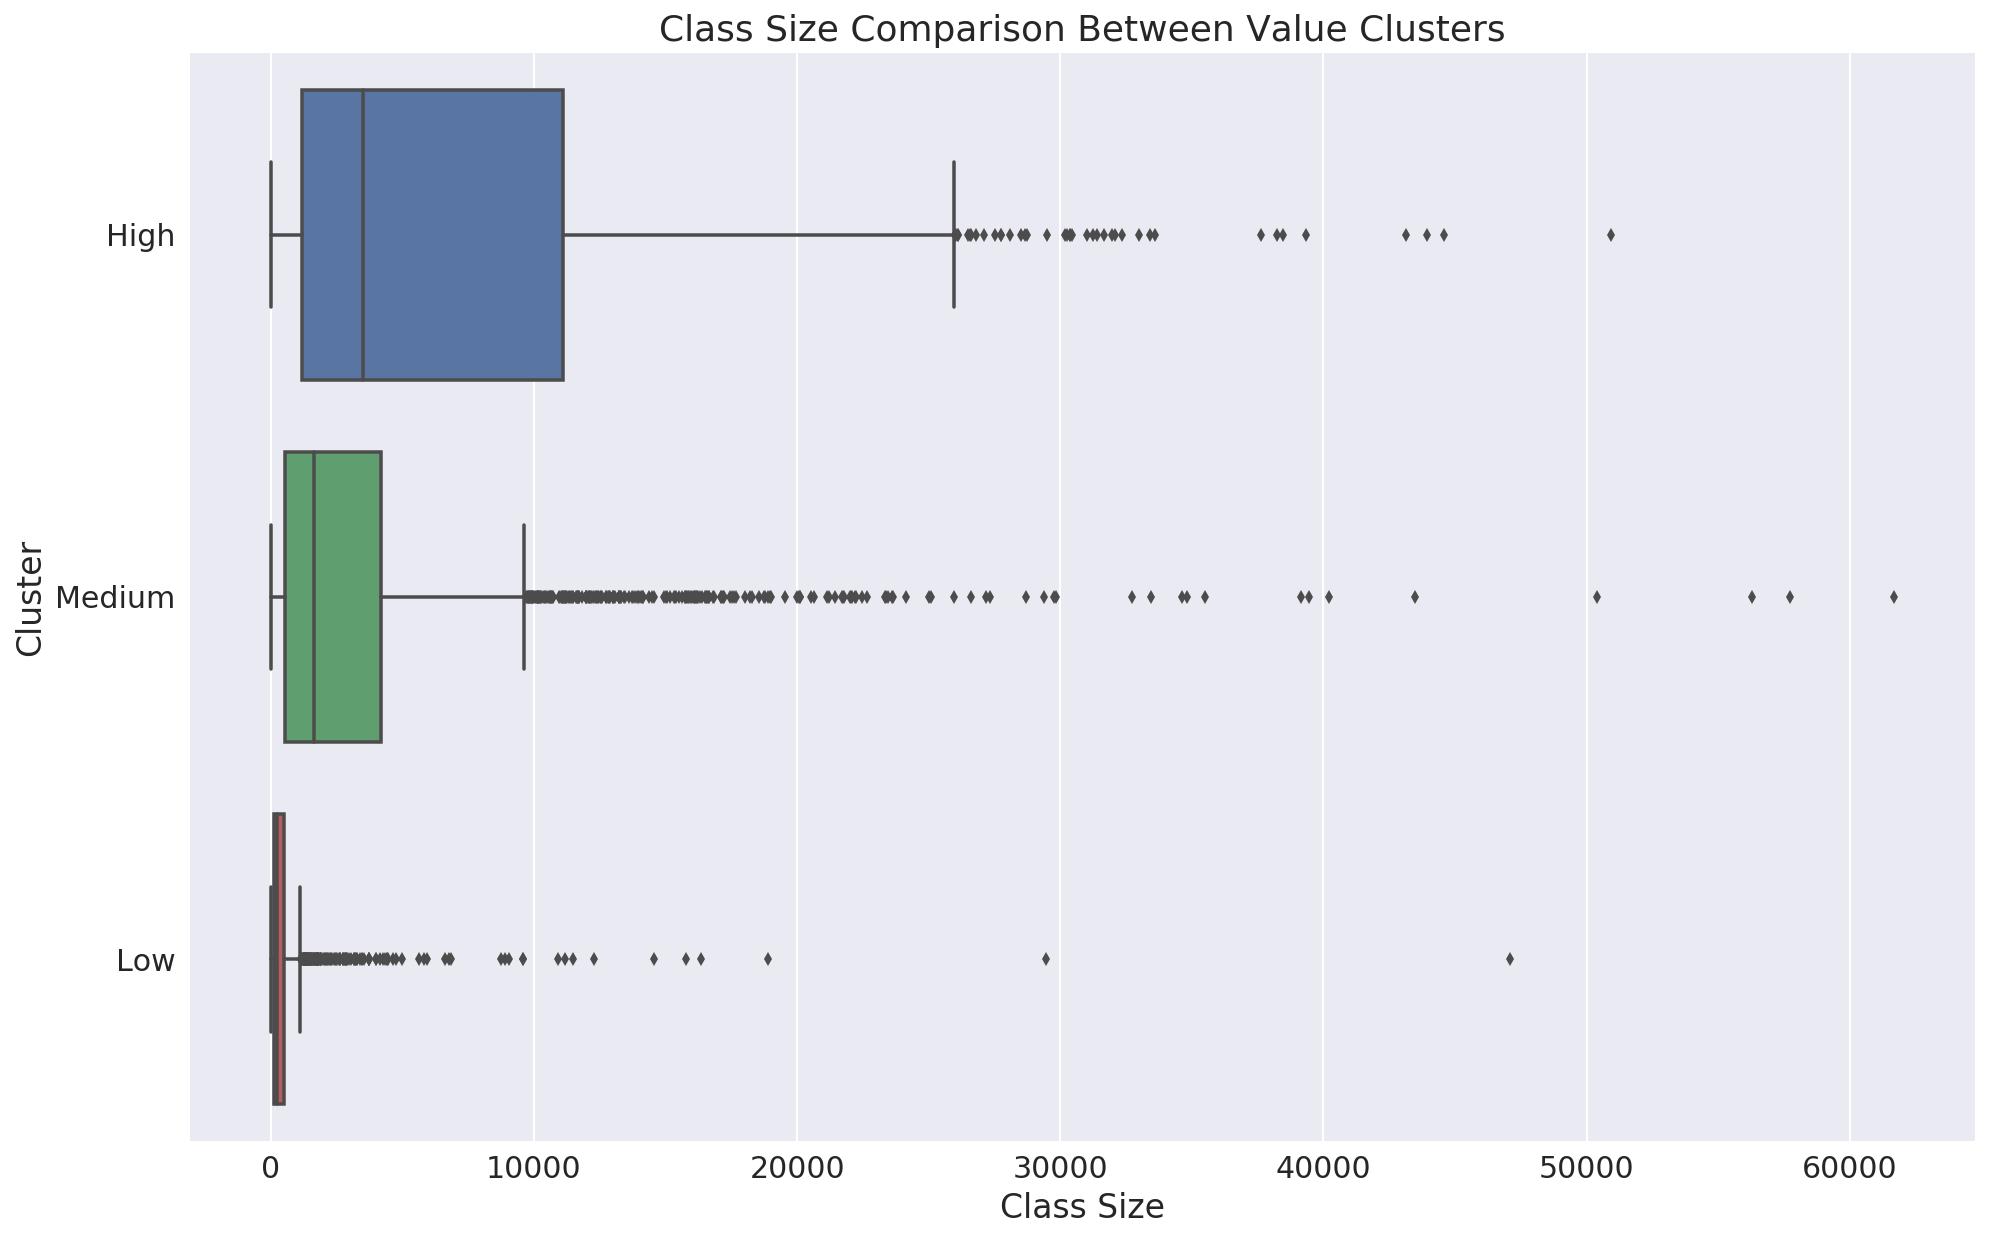

In [117]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x='class_size',
                y='cluster',
                data=school.dropna(subset=['class_size'])[school['class_size'] < 70000],
                order=['High', 'Medium', 'Low'],
                orient='h')
g.set_ylabel("Cluster")
g.set_xlabel("Class Size")
g.set_title("Class Size Comparison Between Value Clusters")

We needed to drop a couple of outliers in our data, as some universities have class sizes above 100,000 students, which made the graph illegible.  As we were curious what these universities are, we have listed them here:

In [118]:
school[school['class_size'] > 50000]

,school,salary,cost,primary_degree,price,admission_rate,completion,owned,class_size,value,finaid,cluster
740,University of Central Florida,48900.0,19815.0,Undergraduate,14048.0,0.4894,0.6724,Public,50919.0,34852.0,5767.0,High
807,Miami Dade College,34100.0,19850.0,Associates,14614.0,NaN,0.3183,Public,61684.0,19486.0,5236.0,Medium
1208,Ivy Tech Community College,32000.0,13547.0,Associates,8911.0,NaN,0.0884,Public,87017.0,23089.0,4636.0,Medium
1318,Ashford University,43400.0,26047.0,Undergraduate,20983.0,NaN,0.2070,For-Profit,50403.0,22417.0,5064.0,Medium
3747,Houston Community College,38200.0,13488.0,Associates,8671.0,NaN,0.1113,Public,57742.0,29529.0,4817.0,Medium
3790,Lone Star College System,38500.0,10231.0,Associates,6141.0,NaN,0.1094,Public,56288.0,32359.0,4090.0,Medium
4611,University of Phoenix-Online Campus,55800.0,19605.0,Undergraduate,14411.0,NaN,0.2000,For-Profit,166816.0,41389.0,5194.0,High


Arizona State has an incredible 166,00 online students, while other outliers come in somewhere between 50,000 and 70,000 students.

It seems that, despite expectations, the highest value universities have, by far, the largest average class sizes.  We believe that high value schools have much higher class sizes than low value schools because the majority of large public state schools fall into this high value cluster.  These state schools tend to be very large, so we assume this explains the enormous average size in this category, while many low-value institutions may be private institutions with a focus on arts of music as we found above.  The low expected income of these types of institutions keeps their class sizes low, we expect.

We can also look at the completion rates among universities in each category.  We expect the completion rates to be highest among the high value cluster.  While these universities tend to be the most difficult, they also tend to be more selective.

Text(0.5,1,'Completion Rates Comparison Between Value Clusters')

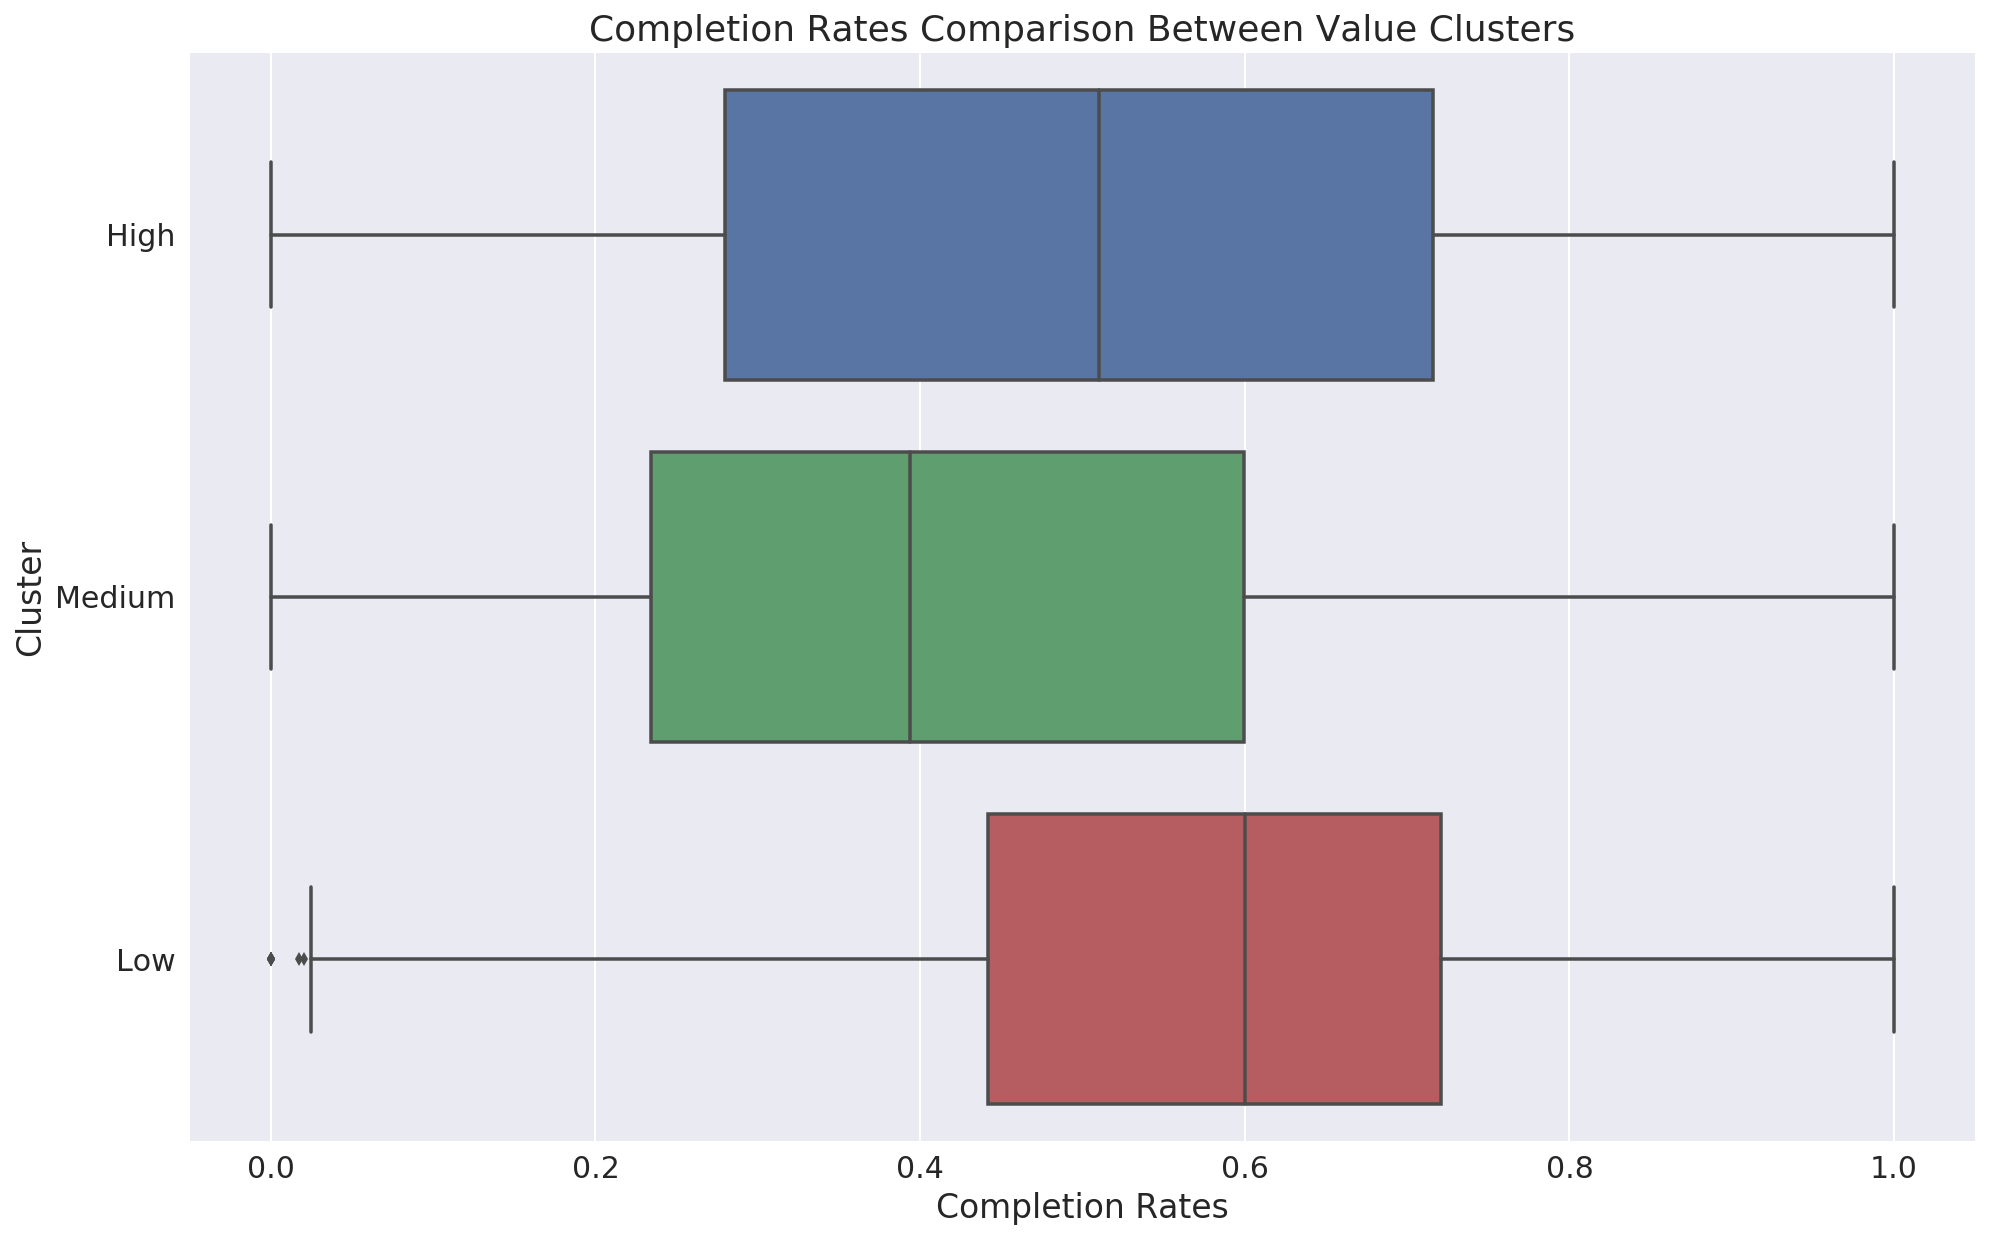

In [119]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x='completion',
                y='cluster',
                data=school.dropna(subset=['completion']),
                order=['High', 'Medium', 'Low'],
                orient='h')
g.set_ylabel("Cluster")
g.set_xlabel("Completion Rates")
g.set_title("Completion Rates Comparison Between Value Clusters")

There is not a huge difference between the averages, but there is certainly a slight trend toward higher completion rates among universities ranked in the highest cluster.  For prospective students, it would probably be most helpful to look at the completion rates of specific universities that each student is considering rather than try to visualize that data here, as the variance is too significant and there is not a strong correlation among clusters.

Finally, we wanted to examine why each university tended to end up in the clusters they were assigned.  We first thought that cost might be the determining factor.

Text(0.5,1,'Cost Comparison Between Value Clusters')

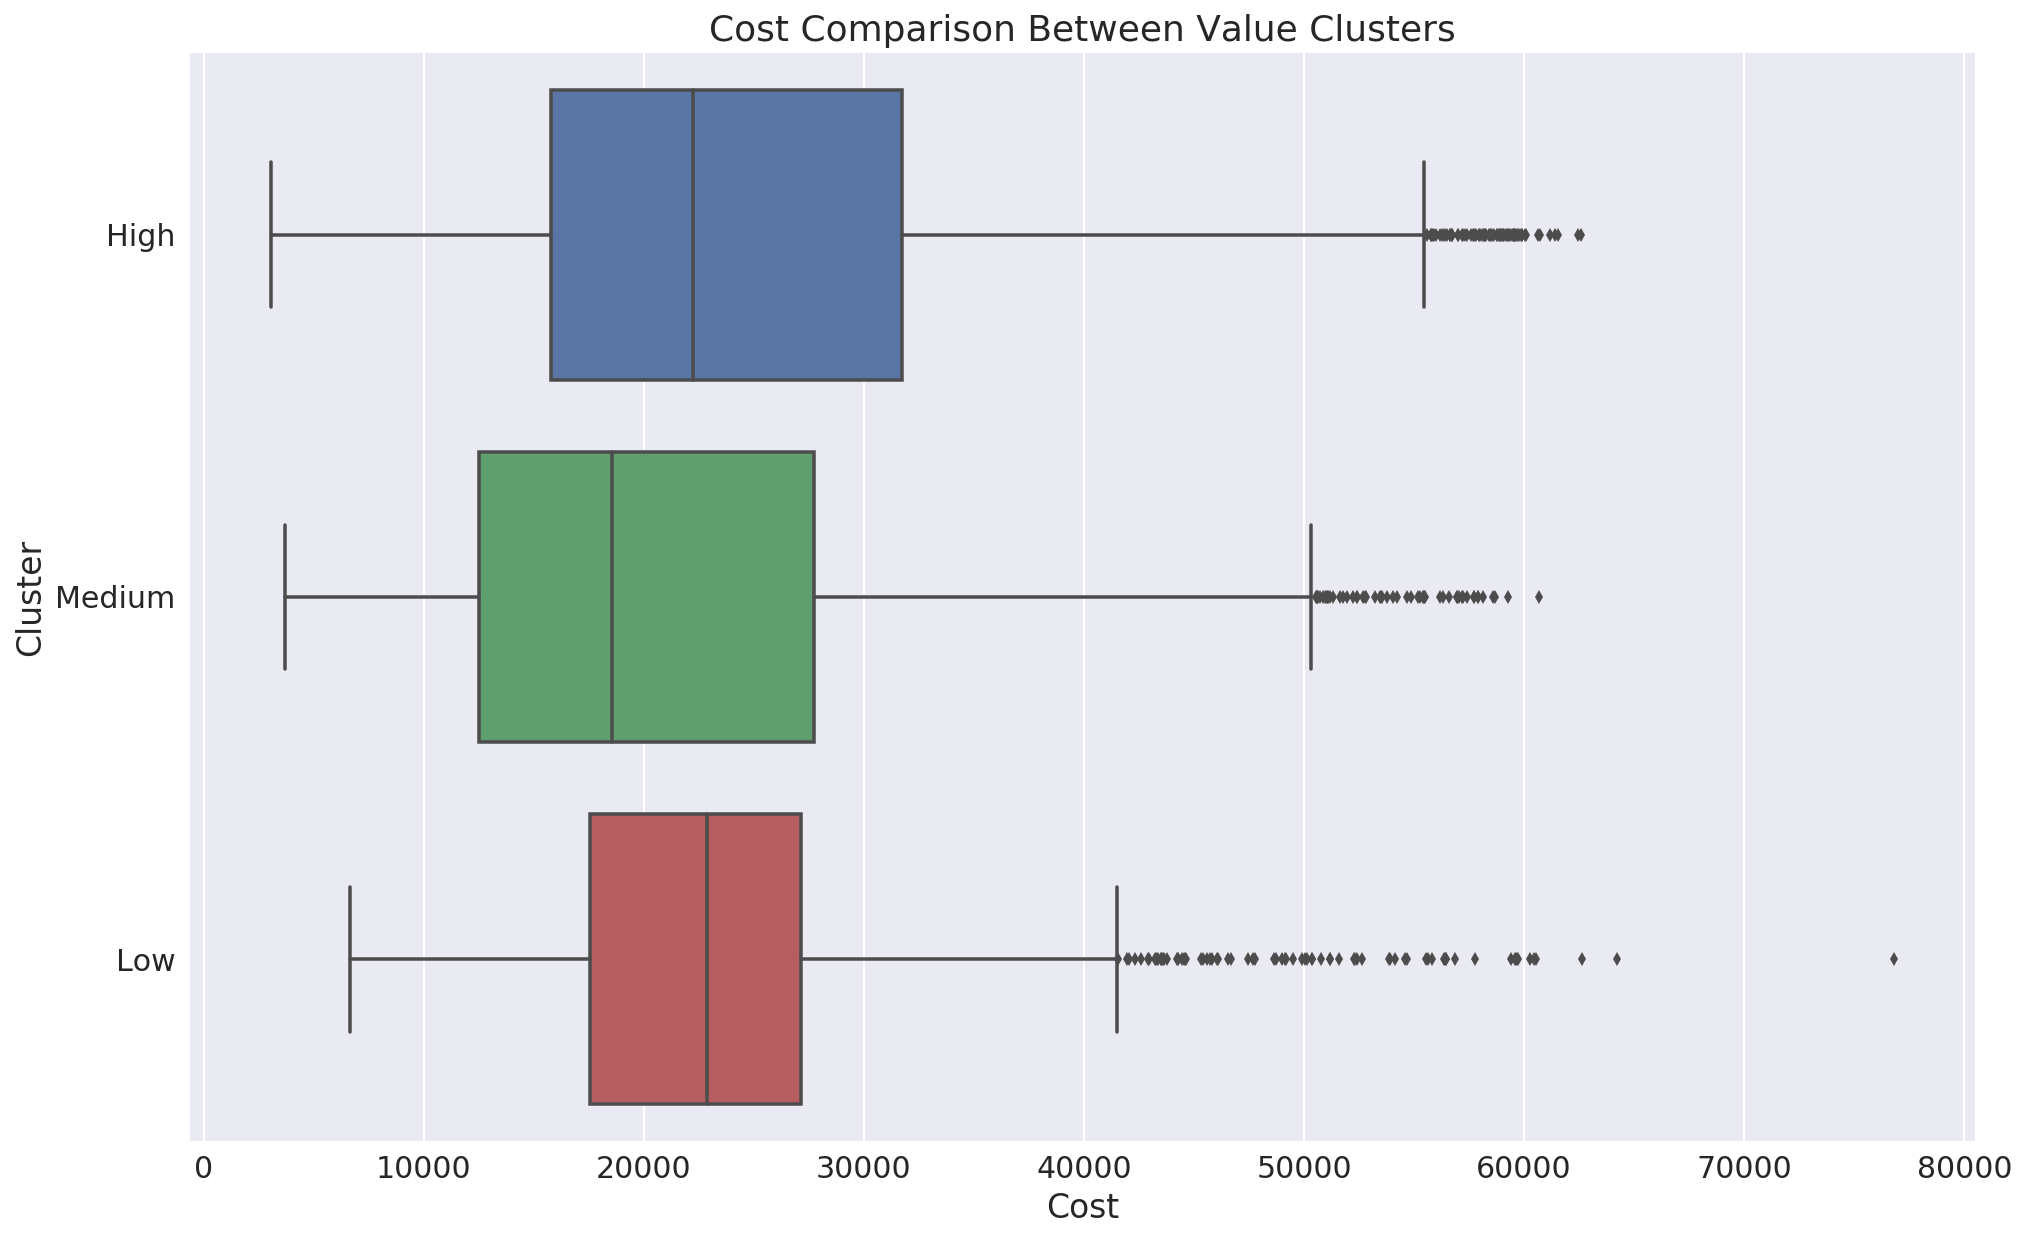

In [121]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x='cost',
                y='cluster',
                data=school.dropna(subset=['cost']),
                order=['High', 'Medium', 'Low'],
                orient='h')
g.set_ylabel("Cluster")
g.set_xlabel("Cost")
g.set_title("Cost Comparison Between Value Clusters")

We can see that the listed cost before any financial aid is not very different between each of these clusters.  In fact, the highest value cluster even has the highest upper first quartile for cost.  We expect, in light of this, that the highest value institutions tend to give the most in financial aid to their students.

Text(0.5,1,'Financial Aid Comparison Between Value Clusters')

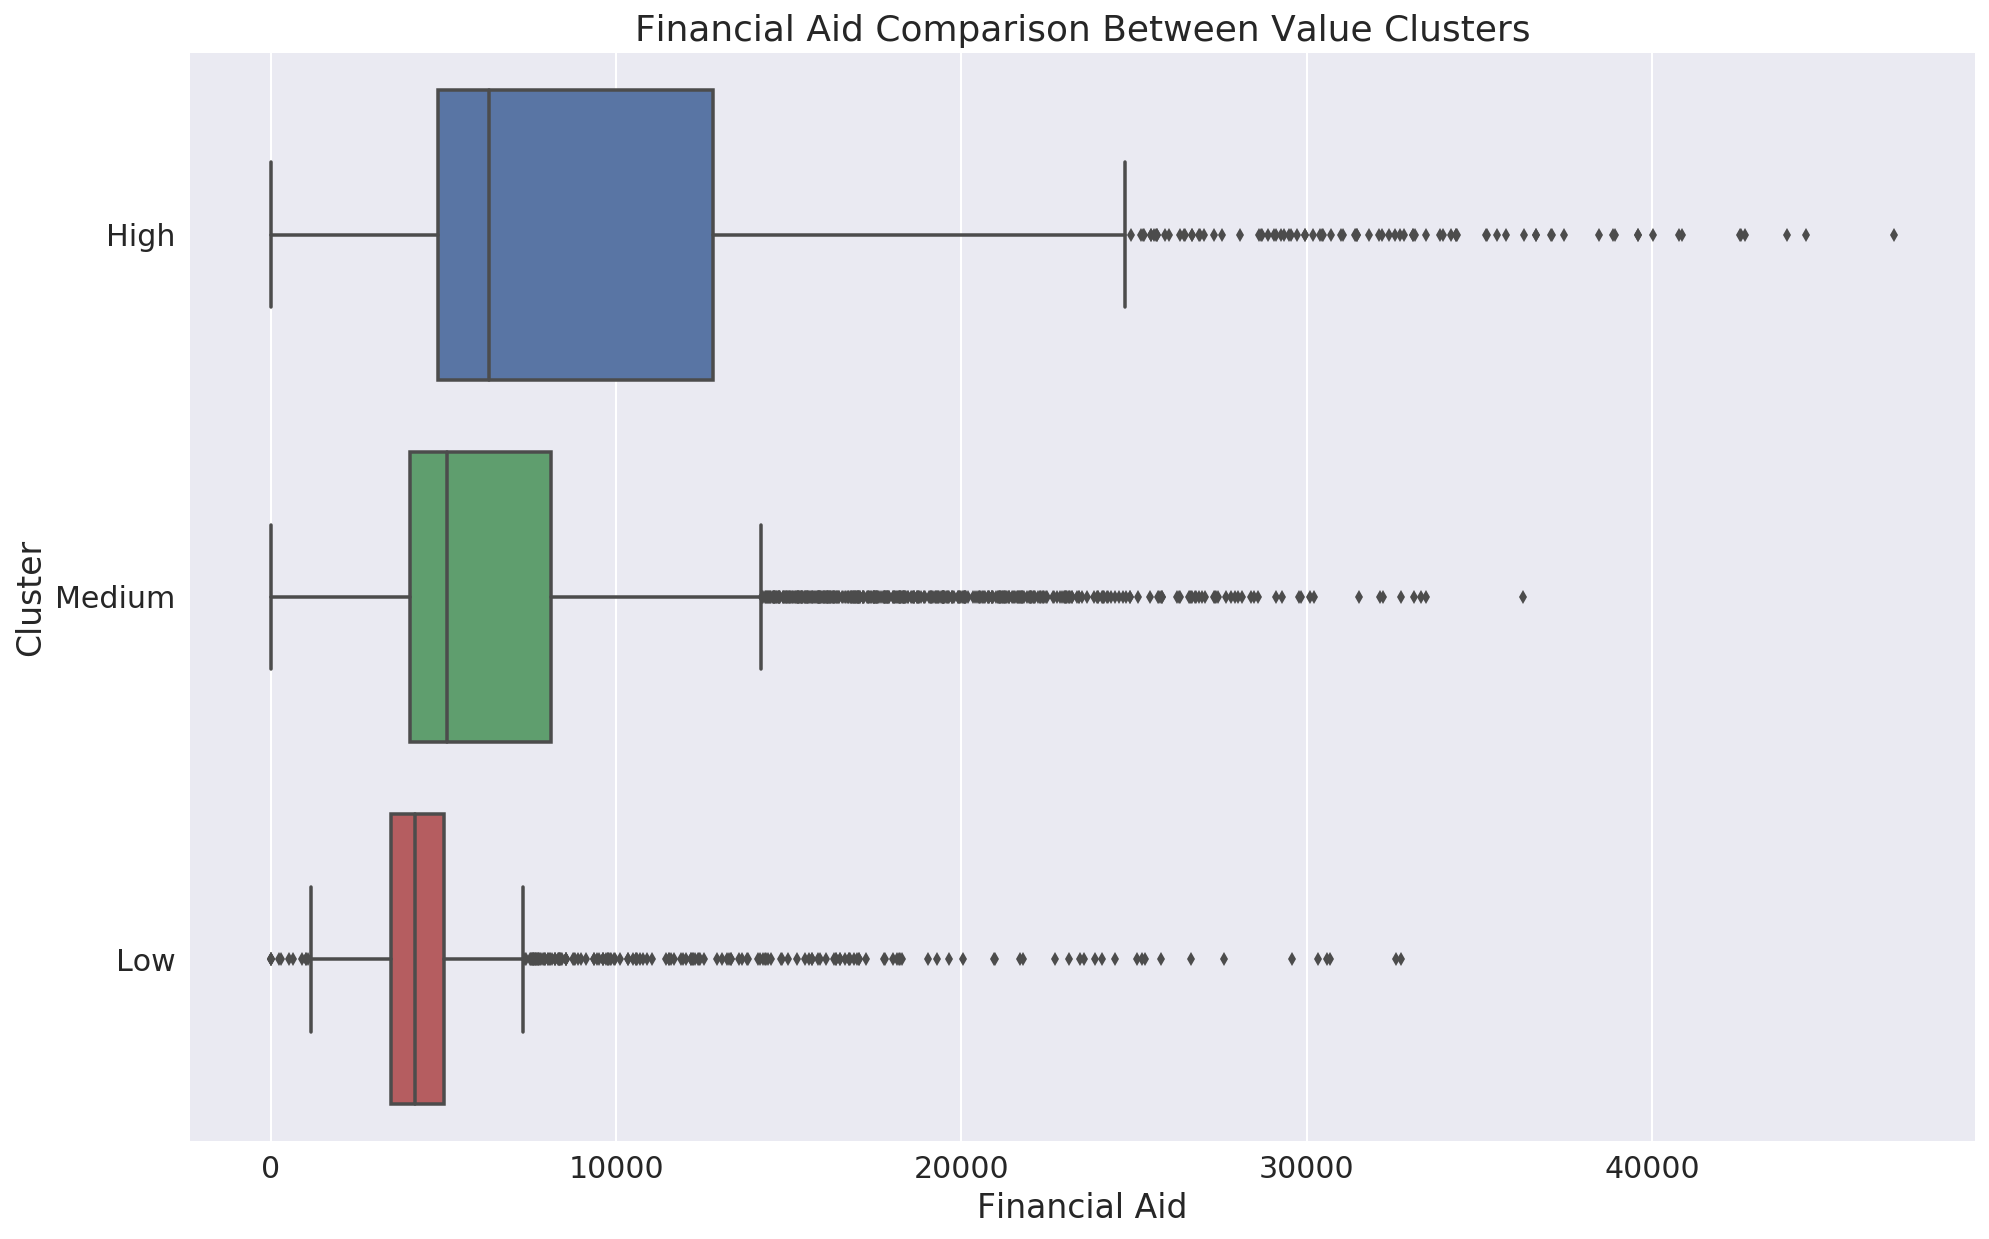

In [122]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x='finaid',
                y='cluster',
                data=school.dropna(subset=['finaid']),
                order=['High', 'Medium', 'Low'],
                orient='h')
g.set_ylabel("Cluster")
g.set_xlabel("Financial Aid")
g.set_title("Financial Aid Comparison Between Value Clusters")

We see that financial aid is definitely primary the reason that most institutions fall into their respective clusters.  High value institutions tend to give significantly more financial aid, on average, to their students than medium or low value universities and medium value universities give much more financial aid on average the lowest value institutions.

### Combining the Localized Salary Data

We now bring in the salary data we collected to aid in our analysis.  To begin, we must emphasize that this analysis only consisted of a specific subset of majors and universities (see code above for data collection) and therefore is not necessarily representative.  In addition, our salary data is localized, so for any particular university we are only looking at the opportunity in a given field in the cities near that university.  In our research, we found that many students do tend to stay in areas surrounding the university they graduate from, especially in areas with high levels of opportunity, but many do not.  Especially with the highest level of schools, like Ivy League Universities, graduates have a great deal of opportunity and may choose to live in a wide variety of locations.  That said, the data is still relavent given the high typical proportions of students who stay in their areas for most universities.

We will begin by loading in our data and then look at how the various schools compare amongst a few different majors.

In [126]:
df = pd.read_csv('data_with_retention.csv')
#df.set_index('school', inplace=True)

df_cs = df.copy()
df_cg = df.copy()
df_ec = df.copy()
df_bio = df.copy()
df_cs = df_cs[df_cs.major == 'computer science' ]
df_cg = df_cg[df_cg.major == 'cognitive science' ]
df_ec = df_ec[df_ec.major == 'economics' ]
df_bio = df_bio[df_bio.major == 'biology' ]


In [127]:
#getting top 10 salaries (getting revelvant data from dataset)
#computer science
df_cs.sort_values('salary', ascending= False)
top10 = pd.DataFrame()

top10cs =pd.DataFrame(
    {'school': df_cs.school,
     'salary': df_cs.salary,
     'cost': df_cs.cost,
     'salary-cost':df_cs.salary-df_cs.cost
    })
top10 = top10cs.copy() #will hold orignial copy 
top10cs = top10.nlargest(10, 'salary-cost') #net salary
top10cs = top10cs.reset_index(drop=True)#reindex

top10css = top10.nlargest(10, 'salary') #salary
top10css = top10css.reset_index(drop=True)#reindex

#cognitive science 
df_cg.sort_values('salary', ascending= False)
top10 = df_cg.nlargest(10, 'salary')
top10cg =pd.DataFrame(
    {'school': top10.school,
     'salary': top10.salary,
     'cost': top10.cost,
     'salary-cost':top10.salary-top10.cost
    })
top10cg = top10cg.reset_index(drop=True)

#for Econ
df_ec.sort_values('salary', ascending= False)
top10 = df_ec.nlargest(10, 'salary')
top10ec =pd.DataFrame(
    {'school': top10.school,
     'salary': top10.salary,
     'cost': top10.cost,
     'salary-cost':top10.salary-top10.cost
    })
top10ec = top10ec.reset_index(drop=True)

#For Biology
df_bio.sort_values('salary', ascending= False)
top10 = df_bio.nlargest(10, 'salary')
top10bio =pd.DataFrame(
    {'school': top10.school,
     'salary': top10.salary,
     'cost': top10.cost,
     'salary-cost':top10.salary-top10.cost
    })
top10bio = top10bio.reset_index(drop=True)

First we will examine computer science sorted by salary.  Here we see the highest salaries among graduates tend to be in areas with higher cost of living, and we do not consider cost of attendance.

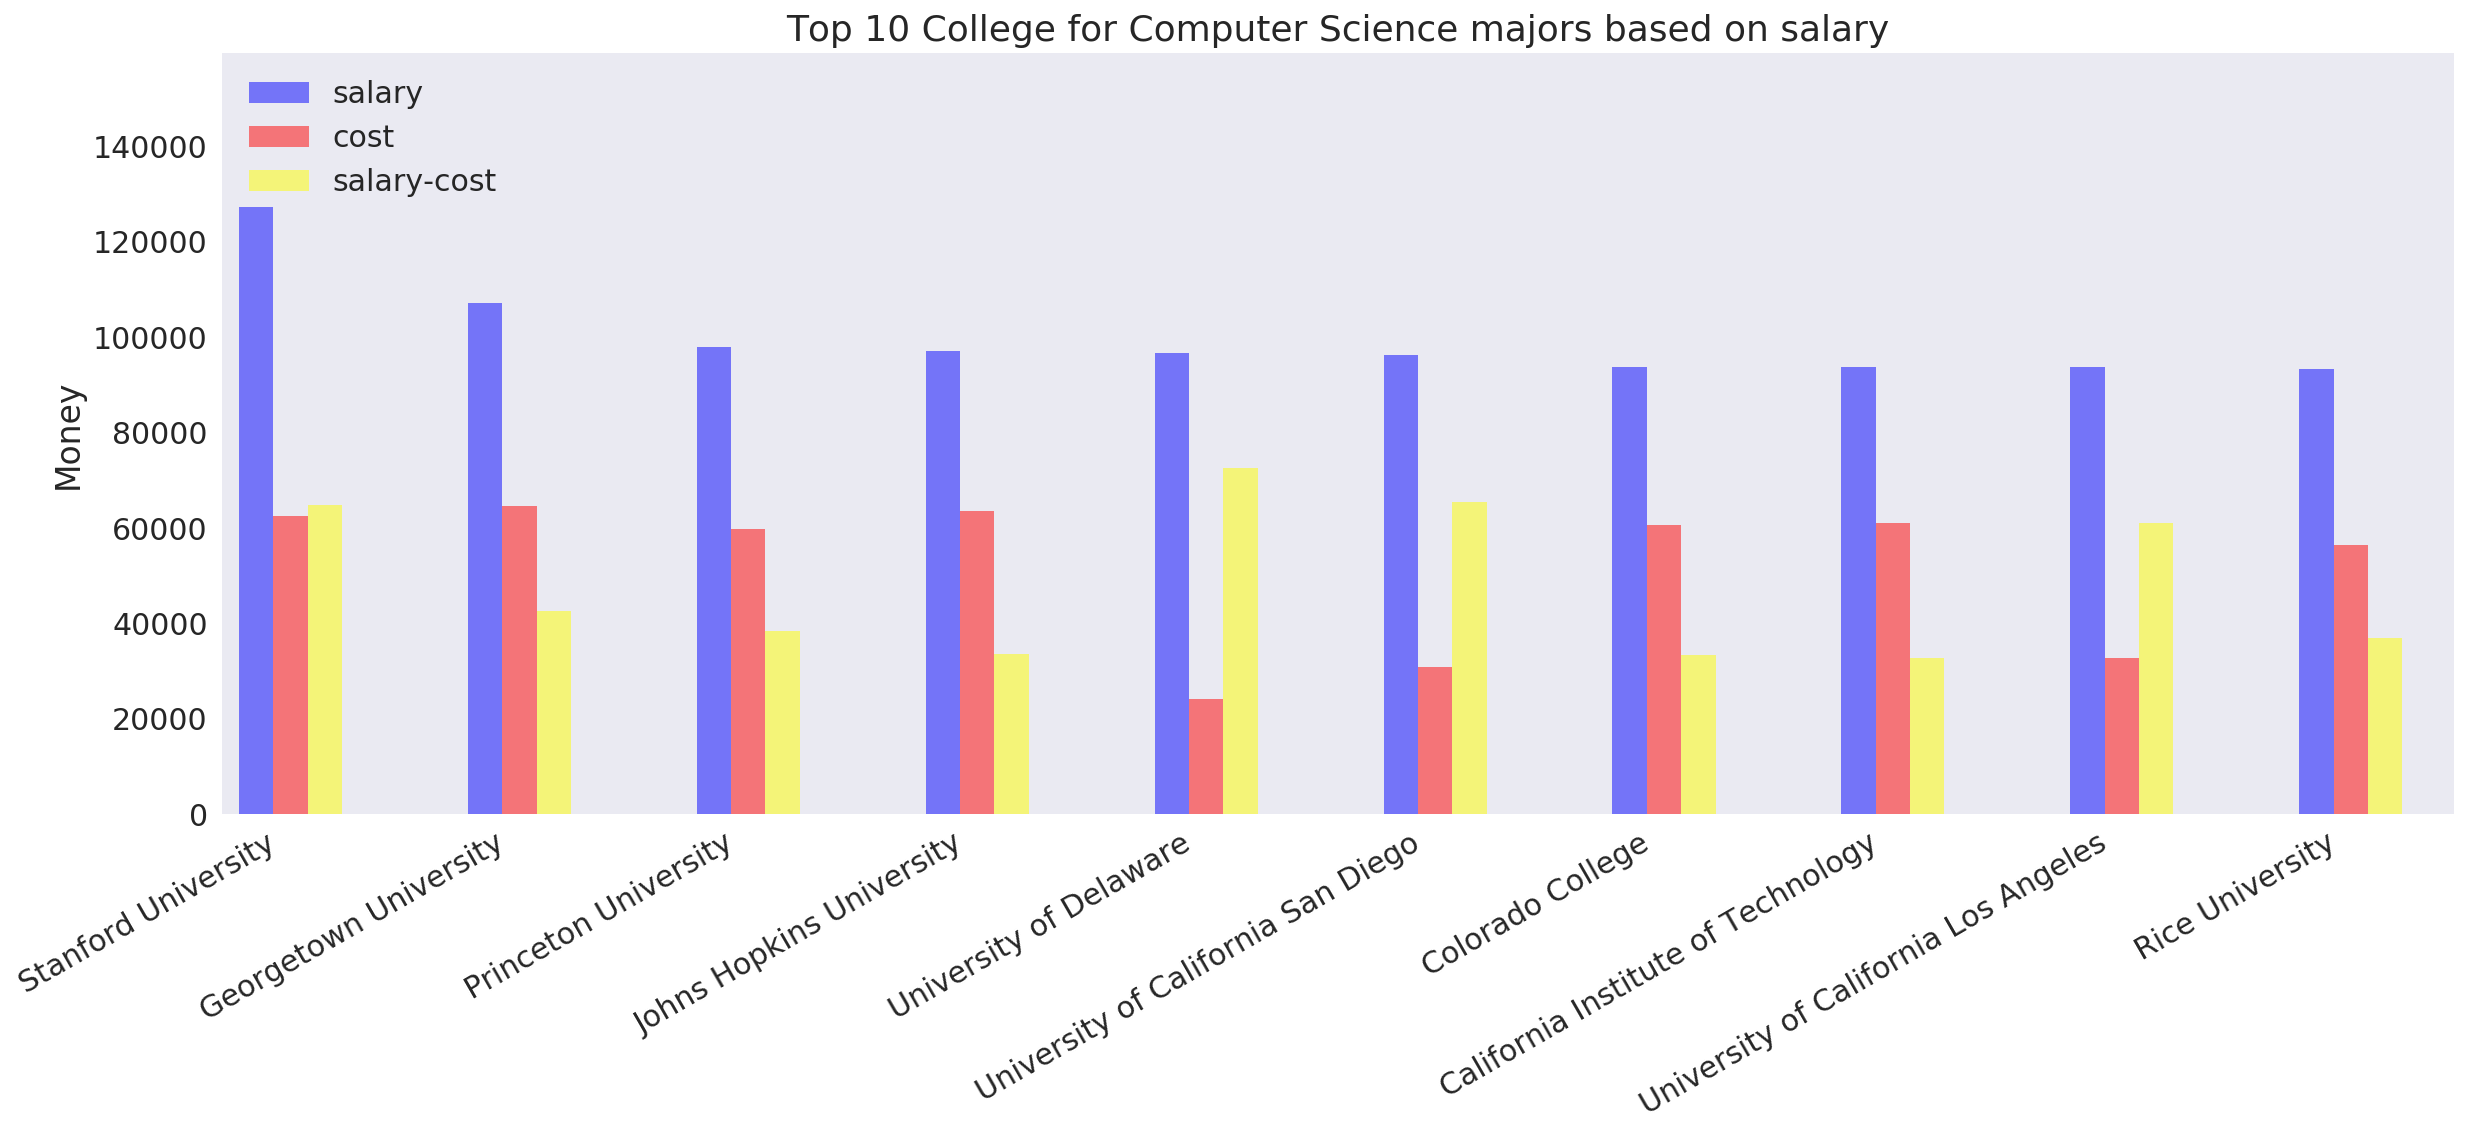

In [128]:
# Setting the positions and width for the bars
pos = list(range(len(top10css['school'])))
width = 0.15

# Plotting the bars
fig, ax = plt.subplots(figsize=(20,7))

# Create a bar with gpa data,
# in position pos,
plt.bar(pos, top10css['salary'], width, alpha=0.5, color='blue', label=top10css['school'][0])
plt.bar([p + width for p in pos], top10css['cost'], width, alpha=0.5, color='red', label=top10css['school'][1])
plt.bar([p + 2*width for p in pos], top10css['salary-cost'], width, alpha=0.5, color='yellow', label=top10css['school'][2])
# Set the y axis label, title, and positions of x
ax.set_ylabel('Money')
ax.set_title('Top 10 College for Computer Science majors based on salary')
ax.set_xticks([p + 0.7 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(top10css['school'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(top10css['salary'] + top10css['cost'] - 30000)] )


# Adding the legend and showing the plot
plt.legend(['salary', 'cost','salary-cost'], loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.grid()
plt.show()

Next, we look at the same data, but sorted by value instead of salary.  These universities offer the best value among the universities we examined when considering cost of attendance against the salary of typical positions in surrounding areas.

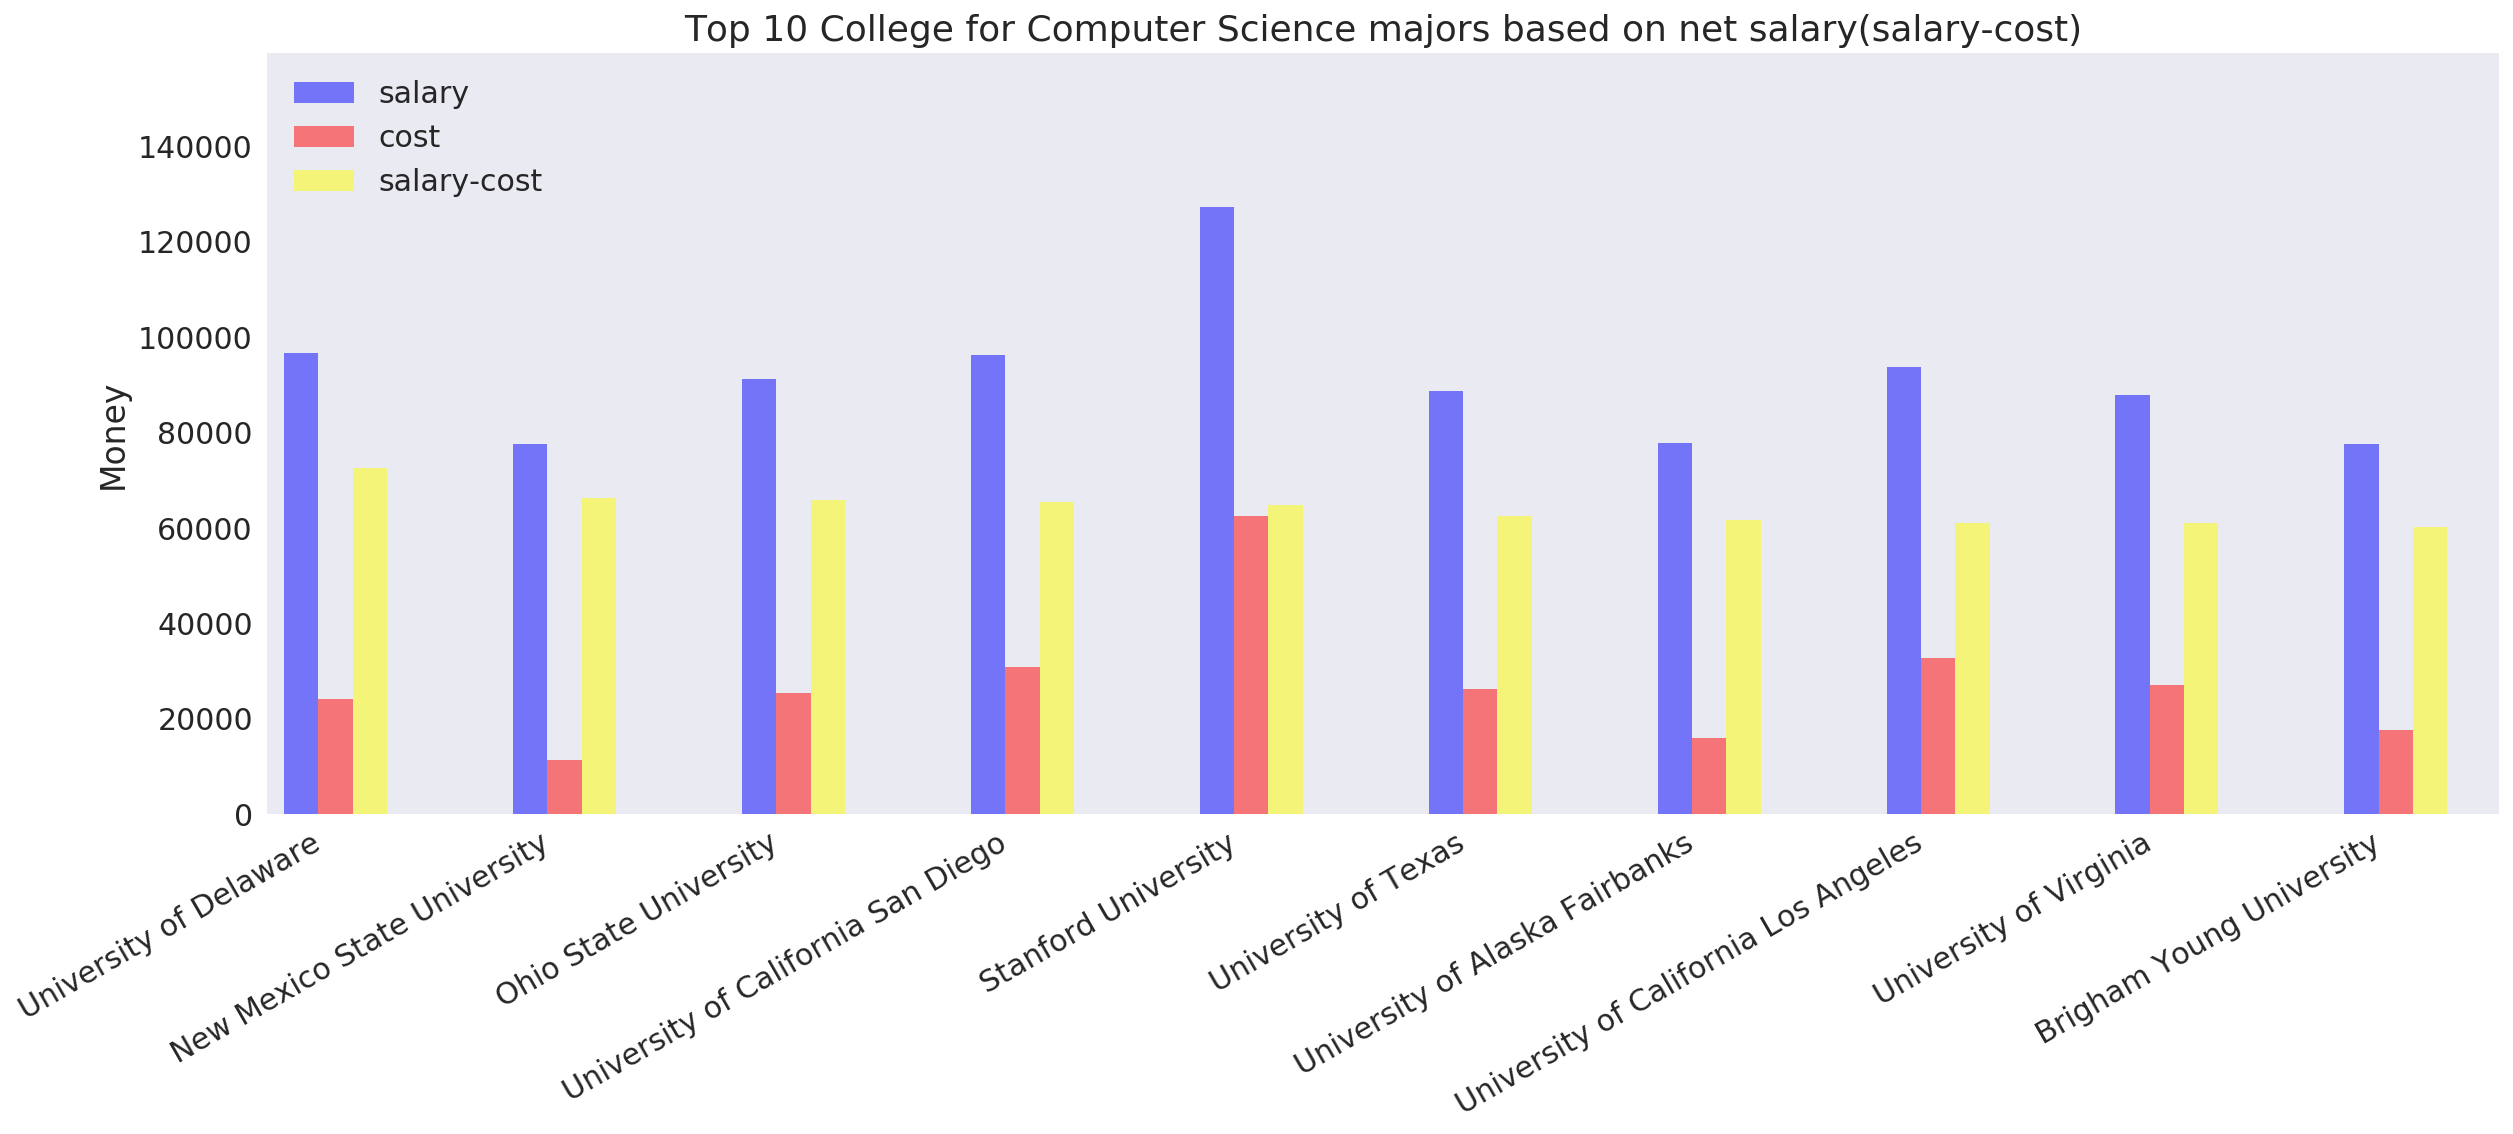

In [129]:
# Setting the positions and width for the bars
pos = list(range(len(top10cs['school'])))
width = 0.15

# Plotting the bars
fig, ax = plt.subplots(figsize=(20,7))

# Create a bar with gpa data,
# in position pos,
plt.bar(pos, top10cs['salary'], width, alpha=0.5, color='blue', label=top10cs['school'][0])
plt.bar([p + width for p in pos], top10cs['cost'], width, alpha=0.5, color='red', label=top10cs['school'][1])
plt.bar([p + 2*width for p in pos], top10cs['salary-cost'], width, alpha=0.5, color='yellow', label=top10cs['school'][2])
# Set the y axis label, title, and positions of x
ax.set_ylabel('Money')
ax.set_title('Top 10 College for Computer Science majors based on net salary(salary-cost)')
ax.set_xticks([p + 0.7 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(top10cs['school'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(top10cs['salary'] + top10cs['cost'] - 30000)] )


# Adding the legend and showing the plot
plt.legend(['salary', 'cost','salary-cost'], loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.grid()
plt.show()

Next, we analyze cognitive science majors in similar fashion, sorted by value.

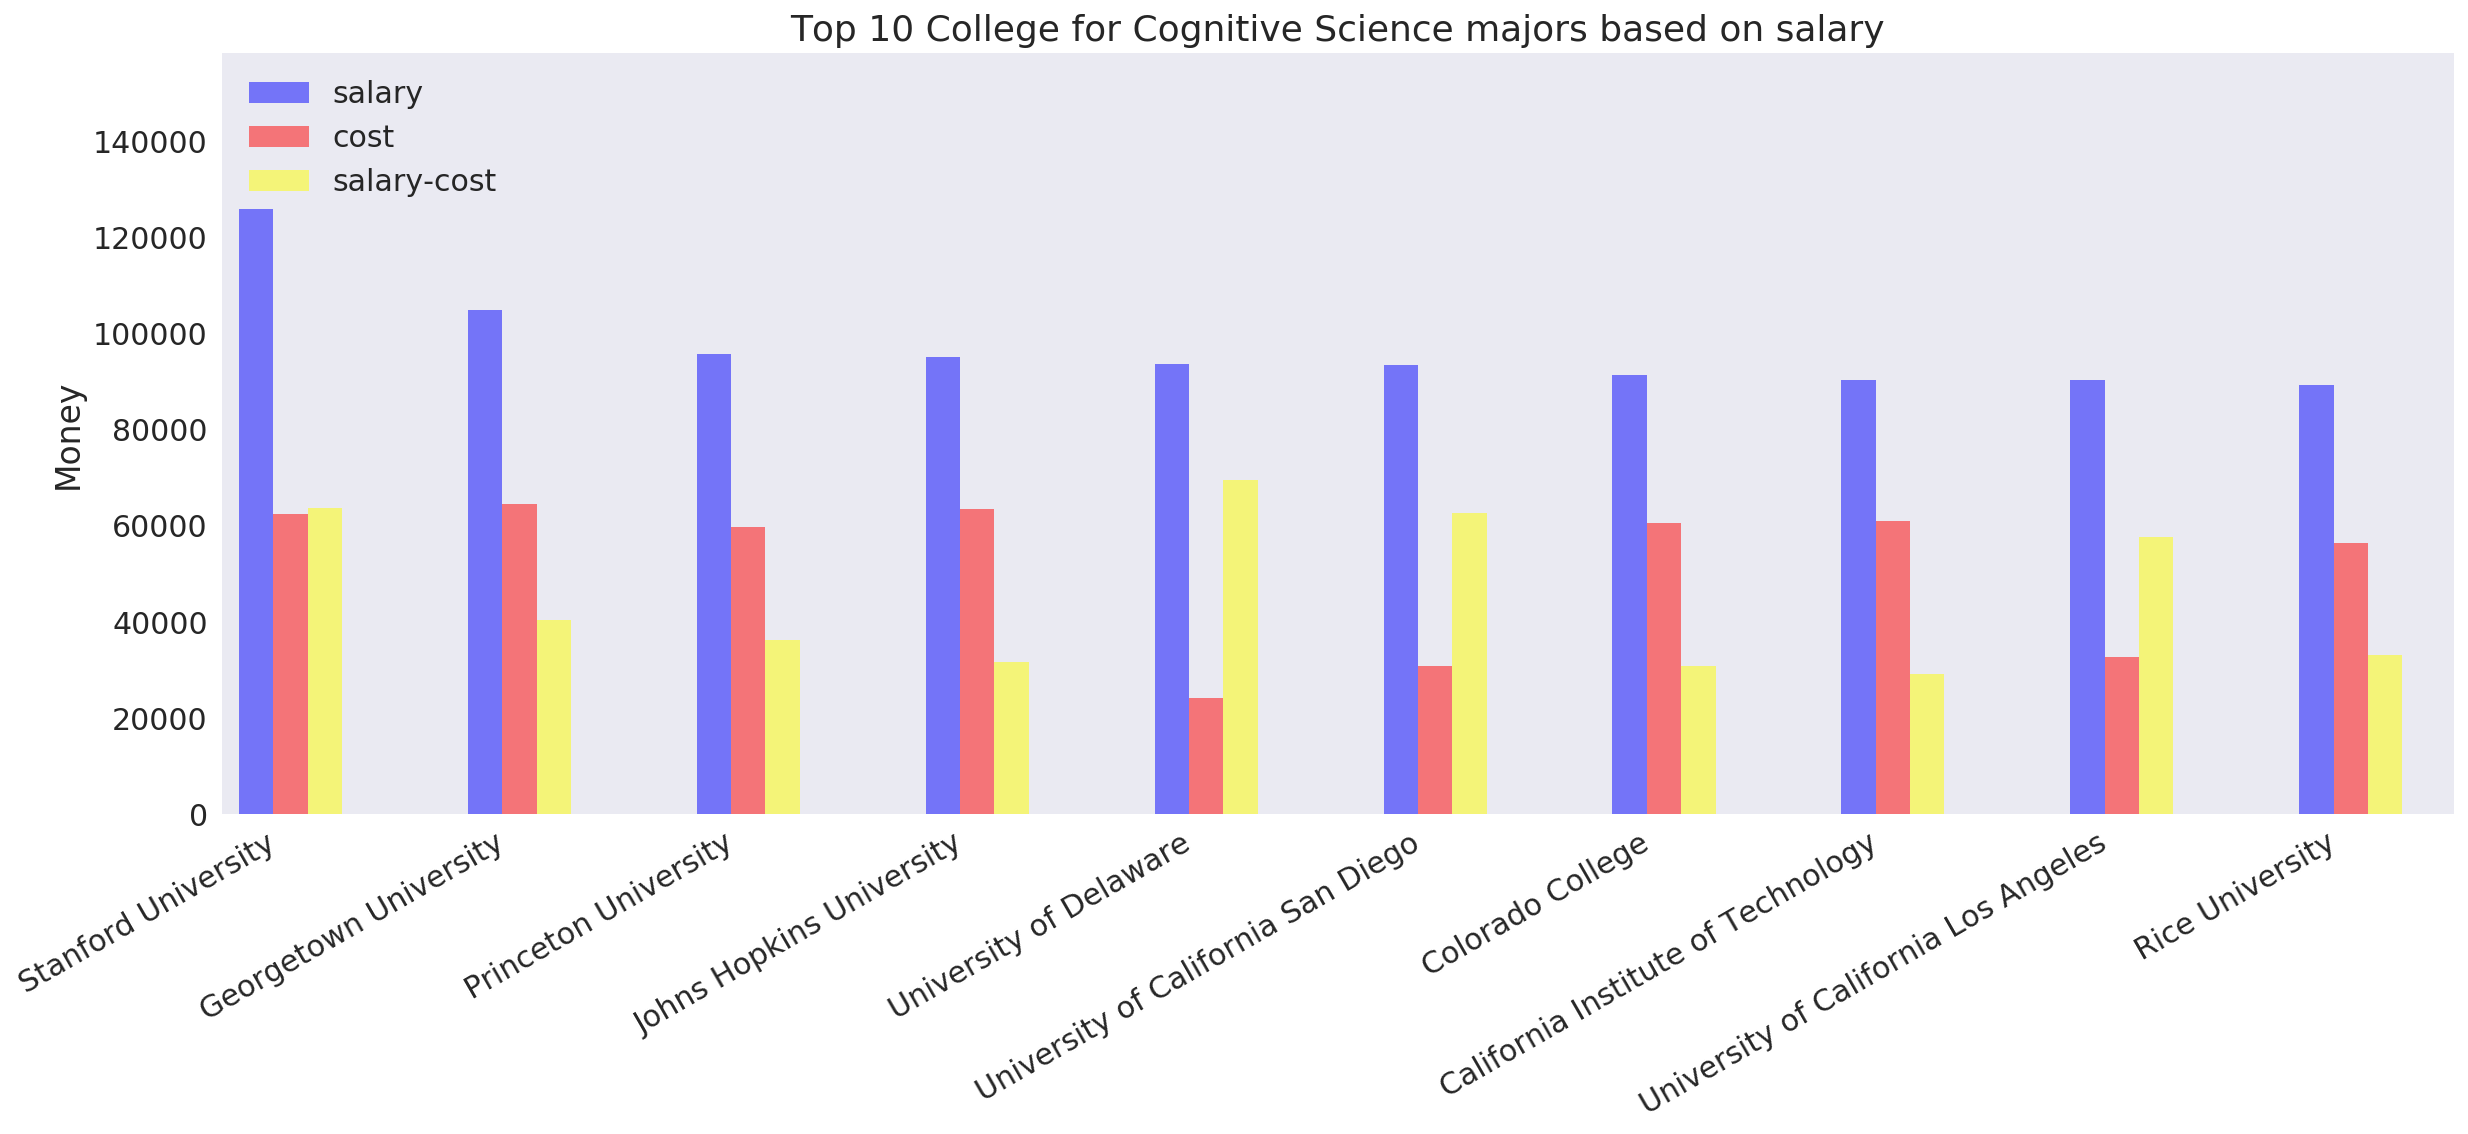

In [130]:
# Setting the positions and width for the bars
pos = list(range(len(top10cg['school'])))
width = 0.15

# Plotting the bars
fig, ax = plt.subplots(figsize=(20,7))

# Create a bar with gpa data,
# in position pos,
plt.bar(pos, top10cg['salary'], width, alpha=0.5, color='blue', label=top10cg['school'][0])
plt.bar([p + width for p in pos], top10cg['cost'], width, alpha=0.5, color='red', label=top10cg['school'][1])
plt.bar([p + 2*width for p in pos], top10cg['salary-cost'], width, alpha=0.5, color='yellow', label=top10cg['school'][2])
# Set the y axis label, title, and positions of x
ax.set_ylabel('Money')
ax.set_title('Top 10 College for Cognitive Science majors based on salary')
ax.set_xticks([p + 0.7 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(top10cg['school'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(top10cg['salary'] + top10cg['cost'] - 30000)] )


# Adding the legend and showing the plot
plt.legend(['salary', 'cost','salary-cost'], loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.grid()
plt.show()

Finally, we take a look at economics majors among different universities, again sorted by value.

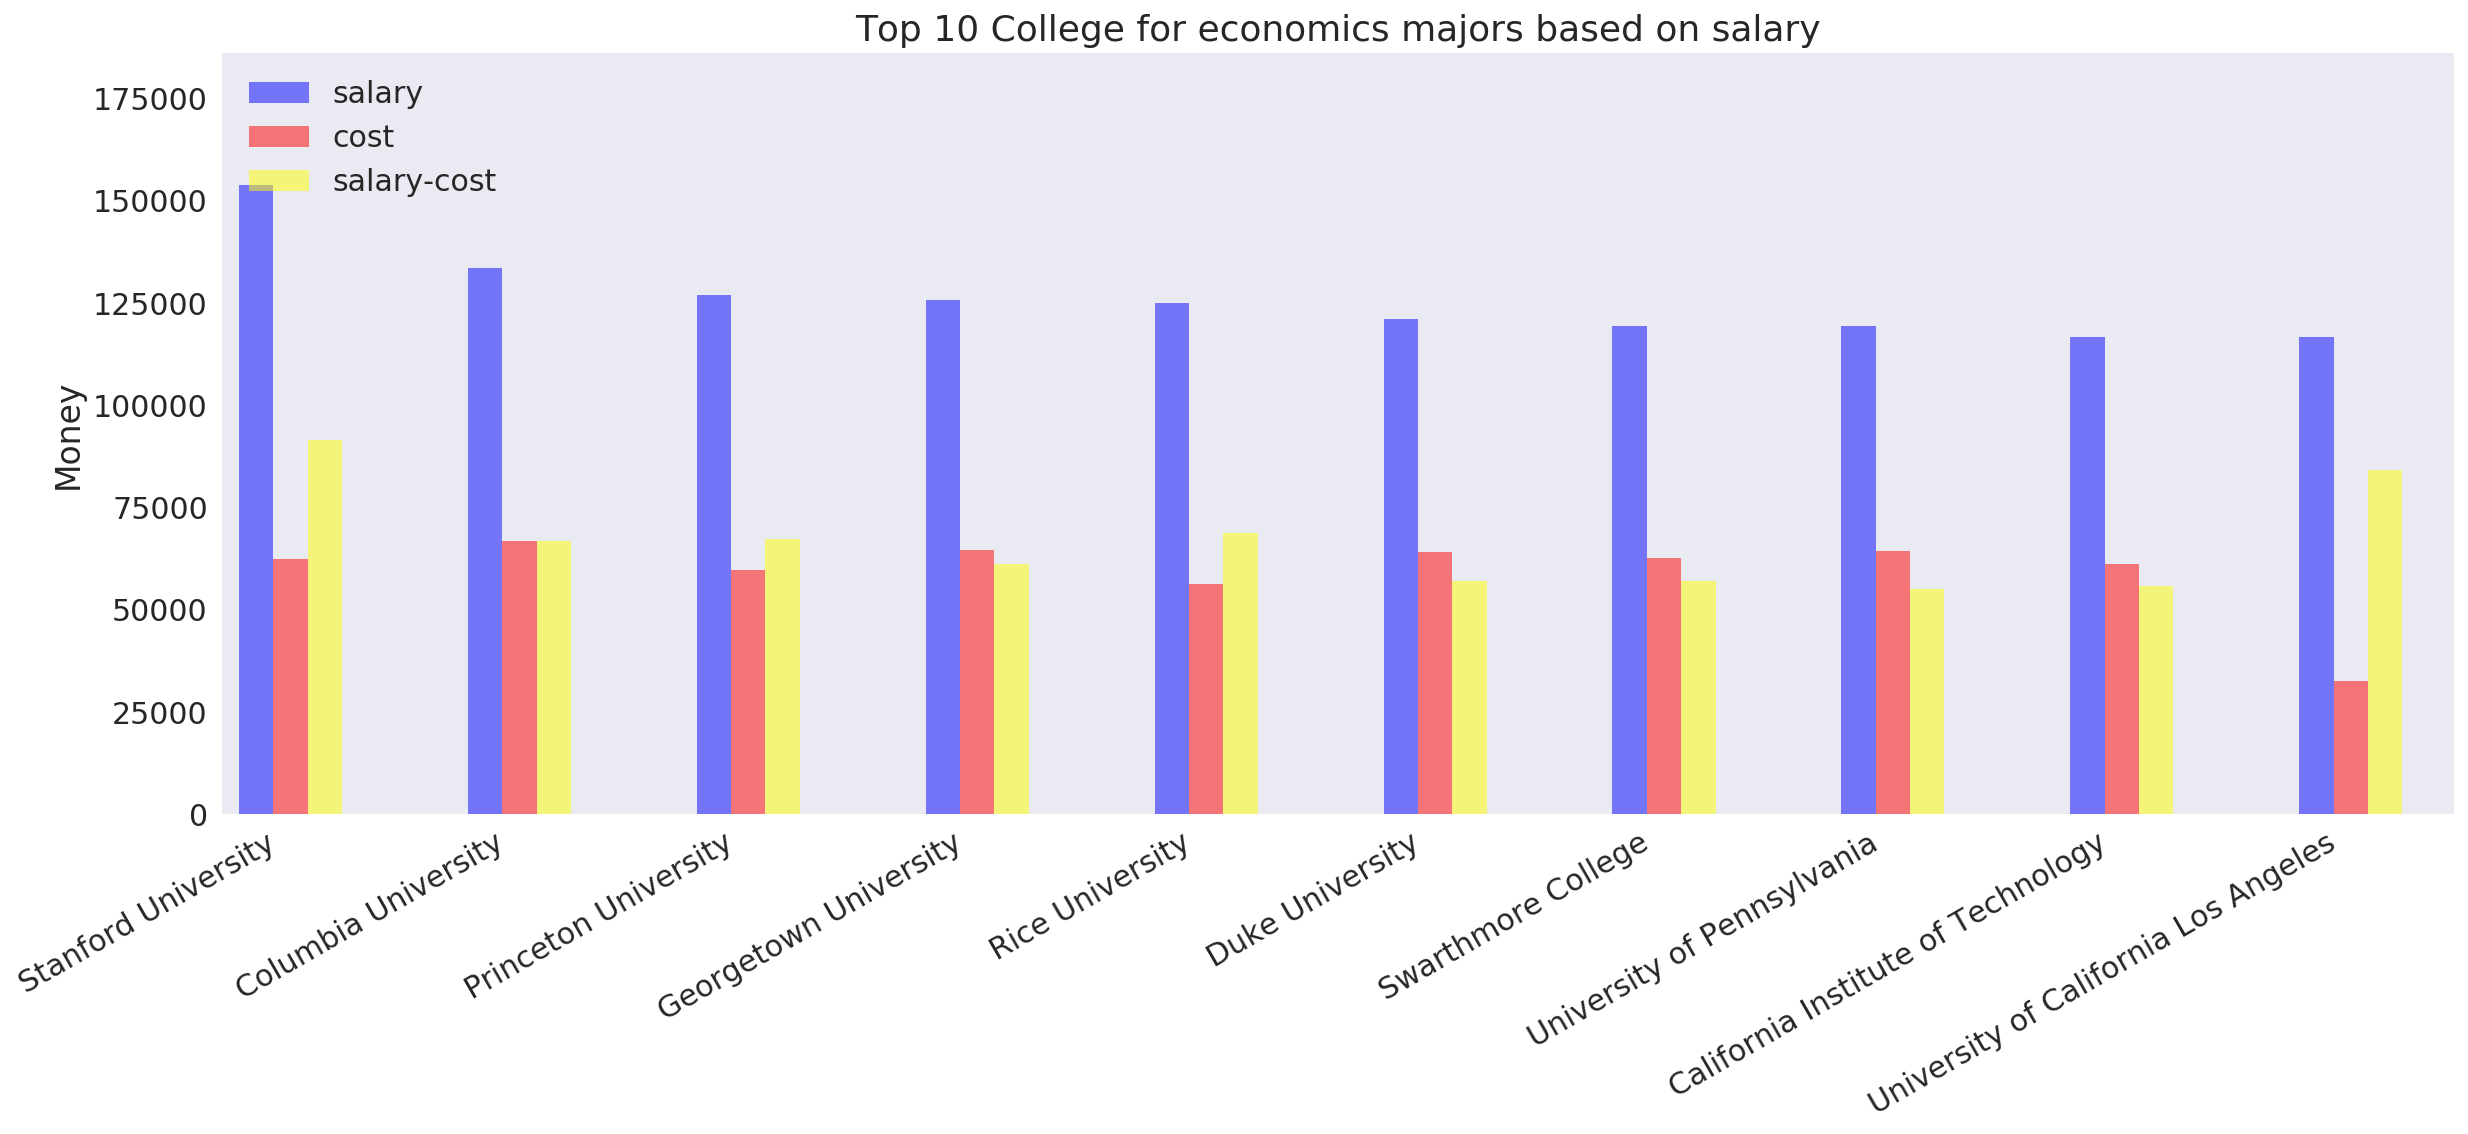

In [131]:
# Setting the positions and width for the bars
pos = list(range(len(top10ec['school'])))
width = 0.15

# Plotting the bars
fig, ax = plt.subplots(figsize=(20,7))

# Create a bar with gpa data,
# in position pos,
plt.bar(pos, top10ec['salary'], width, alpha=0.5, color='blue', label=top10ec['school'][0])
plt.bar([p + width for p in pos], top10ec['cost'], width, alpha=0.5, color='red', label=top10ec['school'][1])
plt.bar([p + 2*width for p in pos], top10ec['salary-cost'], width, alpha=0.5, color='yellow', label=top10ec['school'][2])
# Set the y axis label, title, and positions of x
ax.set_ylabel('Money')
ax.set_title('Top 10 College for economics majors based on salary')
ax.set_xticks([p + 0.7 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(top10ec['school'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(top10ec['salary'] + top10ec['cost'] - 30000)] )


# Adding the legend and showing the plot
plt.legend(['salary', 'cost','salary-cost'], loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.grid()
plt.show()

# <center>Pitfalls of our Analysis</center>


One major consideration with our analysis of localized salaries is that not all students decide to live near their university after graduation.  This is often true, but in our research we found that it can vary dramatically.  For many areas, especially those with higher opportunity like larger cities, retention of graduating students is often very high,  with some areas retaining 80%.  It can be as low as 20% in other areas, so it is important to consider that our estimation is not always an accurate guess of graduating salary for a particular university and major combination.  In examining overall average salaries at the university level, we pull data directly from our original dataset from the Department of Education, so these numbers are highly accurate.

Also, our salary data does not necessarily reflect salaries for junior positions or straight out of college, but rather positions in the field as a whole.  It only accounts for job titles that we have manually entered which, although fairly comprehensive, may not be representative.

The program was not able to account for different housing options for the student and did not account for confounds such as transportation fees, university fees or dining fees. These are prices that should also be factored into a student's final decision, as it may lower estimated costs based on student lifestyle and living situation. This program also does not account for the student's demographics.

Although our analysis did not include these advanced features, it did perform everything we had set out to accomplish.




# Privacy & Ethical Considerations

The data was taken from collegescorecard.ed.gov and from the Burea of Labor Statistics, both of which are governmentally run sources. The data does not look at individuals, but rather looking at statistics based on different demographics. This reduces the potential for private data being inappropriately released.

This analysis is meant to supplement any decisions people would make about their decision for college education. We don't see any reasonable way this analysis can be used for unethical motives. However, unlying confounding factors could bias this analysis, and lead college applicants towards making incorrect decisions for themselves.

# Conclusion/Discussion


Our main goal for this project was to provide analysis of university data that would help prospective students find the optimal school for them. We achieved this by creating visualizations and recommendations that provide the user with information to make informed decisions regarding their choice of school to attend. We conducted the analysis above to learn whether or not we can form accurate predications using the data we gathered. We started by looking at general patterns between schools' rankings and average salaries after graduation. Then we broke the analysis down for specific majors/programs at those schools. We also looked at patterns for different degree levels, finding that, as expected, higher levels of education is directly correlated to salary after graduation. Based on this analysis, we can conclude that using this data can provide prospective students with useful information about different universities and their value to the student based on a specific major/program.

Our hypothesis was that the traditionally highest rating schools would overall perform the best in terms of value.  While this did hold true, we also found a number of universities that provide very high value in terms of costs of living, tuition, and salary after graduation that many people might not expect.  Among these universities, we even found many with extremely high rates of acceptance and high levels of completion.  After breaking down our data into majors, we found that engineering and technology degrees tended to outperform the rest in terms of salary after graduation, confirming our expectation that these would be some of the best investments for prospective students.

There were many factors that we were not able to take into account and would be interesting to see in future analysis.  For example, data about ethnic diversity in universities and data about financial backgrounds were available in the data.  In particular, it would interesting to look at how differing financial backgrounds leads to more availability of financial aid.  This would, theoretically, allow many students of lower socio-economic background to attend a wider variety of university and still find good value.  Students with higher socio-economic backgrounds might be more restricted in their choices if the student was forced to pay their own way.

### References


1) http://time.com/money/collection-post/3829776/heres-what-the-average-grad-makes-right-out-of-college/

2) https://www.collegedata.com/cs/content/content_payarticle_tmpl.jhtml?articleId=10064